## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from os.path import abspath, dirname, basename
from glob import glob
import numpy as np
import pandas as pd
import warnings
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns   
sns.set_style("whitegrid")
import dcor

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# import toybrains
TOUYBRAINS_REPO = os.path.abspath("../../")
if TOUYBRAINS_REPO not in sys.path: sys.path.append(TOUYBRAINS_REPO)

from utils.DLutils import *
from utils.vizutils import *

In [4]:
DEEPREPVIZ_BACKEND = abspath( "../../../Deep-confound-control-v2/application/backend/deep_confound_control/core/")
assert os.path.isdir(DEEPREPVIZ_BACKEND) and os.path.exists(DEEPREPVIZ_BACKEND+'/DeepRepVizBackend.py'), f"No DeepRepViz repository found in {DEEPREPVIZ_BACKEND}. Add the correct relative path to the backend to the 'DEEPREPVIZ_BACKEND' global variable."
if DEEPREPVIZ_BACKEND not in sys.path:
    sys.path.append(DEEPREPVIZ_BACKEND)
from DeepRepVizBackend import DeepRepVizBackend

In [5]:
N_SAMPLES = 5000
EXP_NAME = 'lblmidr-consite'

In [6]:
SHOW_DATASETS_DISTS = False
SHOW_DATASETS_IMAGES = False
SHOW_DATASETS_CORRS = True

RUN_PCA=False
RUN_ICA=False
RUN_LDA=False
RUN_CCA=False
RUN_ICCon=True

## Compute all metrics (DL-act-based $A_{conf}$ scores)

```bash
! python3 run-deeprepvizbackend.py
```
with correct configurations set inside the `run-deeprepvizbackend.py` file

## Load computed logdirs

In [7]:
# select the model runs for which we want to compare the results
cy = '*'
cX = '*'
yX = '*'
exclude = ['debug', 'c1-f3']
def check_excludes(str, excludes_list):
    for exclude in excludes_list:
        if exclude in str:
            return False
    return True

logdirs = sorted(
    list(set([
        (dirname(dirname(log))) for log in glob(f"log/toybrains*_cy{cy}-cX{cX}-yX{yX}*/*/deeprepvizlog") if check_excludes(log, exclude)]
        )))

print("Collected n={} model logs:".format(len(logdirs)))

# drop log folders that are not complete
logdirs = [logdir for logdir in logdirs if len(glob(f"{logdir}/*/deeprepvizlog/DeepRepViz-v1*"))==len(glob(f"{logdir}/*/deeprepvizlog/"))]
print("after dropping incomplete logs n={} logs are still remaining".format(len(logdirs)))
logdirs

Collected n=35 model logs:
after dropping incomplete logs n=35 logs are still remaining


['log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f032',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX025_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX025_SimpleCNN_c1-f032',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX025_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX050_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX050_SimpleCNN_c1-f032',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX050_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy050-cX050-yX025_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy050-cX050-yX025_SimpleCNN_c1-f032',
 'log/toybra

In [8]:
# parallelize the loading of the logs
def process_drvlogdir(deeprepvizlogdir, verbose=1):
    if verbose==1: print("loading from:", deeprepvizlogdir)

    iter_version = basename(dirname(deeprepvizlogdir))
    if verbose==1: print("loading run version:", iter_version)
    # ignore the missing conf_table warning from DeepRepVizBackend
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Provided conf_table")
        drv_backend = DeepRepVizBackend(best_ckpt_by='loss_test')
    drv_backend.load_log(deeprepvizlogdir)

    log = drv_backend.deeprepvizlogs[deeprepvizlogdir]
    ckpt_idx = log['best_ckpt_idx']
    ckptname, log_ckpt = log['checkpoints'][ckpt_idx]
    logdirname = deeprepvizlogdir.split('/')[-3]
    dataset = logdirname.split('_')[3]
    model_name = logdirname.replace(dataset, '').split('__')[-1]
    if verbose==2:
        print(f"{'='*100}\n {model_name} :: \n\t setting: {dataset} ")
        print(f"\t at ckpt: {ckptname} (idx={ckpt_idx}) \n\t ckpt contains: {list(log_ckpt.keys())}")
        print("\t Model accuracy : {}".format({k:f'{v*100:.2f}%' for k,v in log_ckpt['metrics'].items()}))
        
    result = {("Model",k): v for k,v in log_ckpt['metrics'].items()}
    if 'act_metrics' not in log_ckpt:
        print(f"[ERROR] Metrics not computed for {logdirname}/{iter_version} at ckpt={ckptname} (idx={ckpt_idx}). Skipping...")
        
    else:
        for metric_name, metric_scores in log_ckpt['act_metrics'].items():
            if verbose==2: print(f"\t {'-'*10} \t Metric = {metric_name} \t {'-'*30}")
            for key in ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']:
                if verbose: print("\t {} \t=\t {:.4f}".format(key, metric_scores[key]))
                result.update({(key, metric_name): metric_scores[key]})

    return (dataset, model_name, iter_version), result, drv_backend

## Print computed logdirs & metrics

In [9]:
# collect the DeepRepViz backend results in a dict
def collect_deeprepviz_results(logdirs, verbose=1, n_jobs=-1):

    # for each logdir extract the list of all runs
    logdirs_runs = []
    for logdir in logdirs:
        logdirs_runs.extend(sorted(glob(f"{logdir}/*/deeprepvizlog")))

    all_results_drvs = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(process_drvlogdir)(drvlogdir, verbose) for drvlogdir in tqdm(logdirs_runs))
    
    if len(all_results_drvs)==0:
        print("[ERROR] No results were loaded. Exiting...")
        return None
    
    all_results = {keys: results for keys, results, _ in all_results_drvs}
    
    df_results = pd.DataFrame.from_dict(all_results, orient='index')
    df_results.index = df_results.index.set_names(['dataset', 'model_name', 'trial'])
    # first sort by model name, then by data setting and finally by trial
    df_results = df_results.sort_index(level='trial').sort_index(level='dataset',
                                       key=lambda x: x.str[-3:].astype(int)*10 + (x.str[2:5].astype(int) * x.str[8:11].astype(int))/2)
    # sort the columns by model name and then by metric name
    df_results = df_results.sort_index(axis=1, level=[0,1])
    
    return df_results


#################################################################################################################
df_results = collect_deeprepviz_results(logdirs, verbose=0, n_jobs=10)

  0%|          | 0/105 [00:00<?, ?it/s]

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
A worker stopped while some jo

In [10]:
print("loaded {} rows with {} models, {} unique datasets per model with upto {} trials per dataset.".format(len(df_results), 
                                            (df_results.index.get_level_values('model_name').nunique()), 
                                            (df_results.index.get_level_values('dataset').nunique()), 
                                            (df_results.index.get_level_values('trial').nunique())))

# show the table
df_results.style.bar(vmin=0, vmax=1)

loaded 105 rows with 3 models, 12 unique datasets per model with upto 3 trials per dataset.


See average values across trials

In [11]:
df_results.reset_index().groupby(['dataset', 'model_name',]).mean(numeric_only=True).style.bar(vmin=0, vmax=1)

dropping on a non-lexsorted multi-index without a level parameter may impact performance.


### Plot the results

In [12]:
# def plot_deeprepviz_results(df_results, 
#                             filter = '',
#                             norm_metrics = '', #'dcor|mi|con|r2',
#                             ylim = None):
#     # drop the indexes 'model_name' and 'trial' and only keep the 'data_setting' as index
#     df = df_results.copy().reset_index(level=['model_name', 'trial'])
#     for feas, dfi in df.groupby('model_name'):
#         # drop the loss
#         loss_cols = dfi.columns[dfi.columns.get_level_values(1).str.contains('loss')].values.tolist() 

#         dfi = dfi.drop(columns=[('model_name', ''),('trial', ''), *loss_cols])
#         # flatten the multi-index columns
#         dfi.columns = [' | '.join(col[::-1]).strip() for col in dfi.columns.values]
#         # drop the costeta columns and additional user-defined filters
#         dfi = dfi.filter(regex='^(?!.*costeta)')
#         # sort the index by 10*(X<-y) + (X<-c * c->y)/2
#         dfi = dfi.sort_index(lambda x: 
#                              int(x.str[-3:])*10 + (int(x.str[2:5]) * int(x.str[8:11]))/2)
    
#         # sort the columns alphabetically
#         dfi = dfi.reindex(sorted(dfi.columns), axis=1)
        
#         # normalize the metrics requested
#         if norm_metrics != '':
#             metric_cols = dfi.columns.str.contains(norm_metrics)
#             dfi.loc[:, metric_cols] = dfi.loc[:, metric_cols].apply(
#             lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=1)
    
#         # apply 
#         if filter != '':
#             dfi = dfi.filter(regex=filter)
#         assert dfi.shape[0] > 0, f"No columns remained after applying the filter: {filter}"

#         # plot the results
#         fig, ax = plt.subplots(figsize=(16, 6))
#         g = sns.lineplot(dfi, err_style="bars", ax=ax)
#         sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.5, 1.5), ncols=4)
        
#         ax.set_title(f"DL model settings: {feas.split('_')}")
#         if ylim is not None or norm_metrics!='':
#             ax.set_ylim(ylim)

#         # on the x-axis ticks show the total X<-y and the total X<-c->y
#         new_xticklabels = []
#         majorticks = [-1]
#         last_Xy = -1
#         last_Xcy = -1
#         for lbl in ax.get_xticklabels():
#             cy, cX, yX  = lbl.get_text().split('-')
#             cy = int(cy[-1])
#             cX = int(cX[-1])
#             yX = int(yX[-1])
#             total_Xy = 100*(yX)/4
#             total_Xcy = 100*(cX*cy)/16
#             # add a major tick label every time the total_Xy changes
#             if total_Xcy - last_Xcy >= 95:
#                 majorticks.append(lbl.get_position()[0])

#             if total_Xy != last_Xy:
#                 new_xticklabels.append(f'Xy={total_Xy:3.0f}%      {total_Xcy:3.0f}%')
#                 last_Xy = total_Xy
#             else:
#                 new_xticklabels.append(f'{total_Xcy:3.0f}%')
        
#         ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)
#         # vertical lines to show transition of X<-c->y
#         for x_line in majorticks:
#             ax.axvline(x_line, color='grey', ls='--', lw=0.8, alpha=0.5)
#             ax.vlines(x_line, 0, -0.25, color='grey', ls='--', lw=0.8,
#                     clip_on=False,
#                     transform=ax.get_xaxis_transform())
#         # ax.set_xlim(-1, majorticks[-1]+1)
#         ax.set_xlabel(r'Increasing confound signal [$X \leftarrow c \to y$]'+'\n'+r'   &   True signal  [$X \leftarrow y$] ', fontsize=15)
    
#         plt.show()


# #############################################################################################################
# plot_deeprepviz_results(df_results, filter='Model.*', 
#                         norm_metrics='', ylim=(0,1))

## New metrics: CCA / PCA / ICA

In [13]:
logdir_runs =sorted([l for logdir in logdirs for l in glob(f"{logdir}/*/deeprepvizlog")])
logdir_runs

['log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_0/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_1/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_2/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_0/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_1/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_2/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_0/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_1/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_2/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f032/trial_0/deeprepvizlog',
 'log/toybrains_n500

### Load activations $H^{(l-1)}$ for all trials

In [14]:
# load the activation at the resp. best checkpoints of the model
logs = []
for logdir_run in logdir_runs:
    (dataset, model_name, run), _, drv = process_drvlogdir(logdir_run, verbose=0)
    log = drv.deeprepvizlogs[logdir_run]
    act = log['checkpoints'][log['best_ckpt_idx']][1]['acts']
    test_acc = log['checkpoints'][log['best_ckpt_idx']][1]['metrics']['BAC_test']
    logs.append((dataset, model_name, run, {
        'best_ckpt_idx': log['best_ckpt_idx'],
        'IDs': log['IDs'],
        'y': log['labels'].astype(float),
        'test_acc': test_acc,
        'act': act,

        'y_pred': log['checkpoints'][log['best_ckpt_idx']][1]['preds_0'].astype(float),
        'y_pred_weights': log['checkpoints'][log['best_ckpt_idx']][1]['weights_0'], 
        'y_pred_biases': log['checkpoints'][log['best_ckpt_idx']][1]['biases_0'],
        
    }))
    print(f"activation loaded from {logdir_run} with shape {act.shape}")

activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_0/deeprepvizlog with shape (5000, 32)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_1/deeprepvizlog with shape (5000, 32)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_2/deeprepvizlog with shape (5000, 32)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_0/deeprepvizlog with shape (5000, 256)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_1/deeprepvizlog with shape (5000, 256)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_2/deeprepvizlog with shape (5000, 256)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_0/deeprepvizlog with shape (5000, 3)
activation loaded from lo

In [15]:
unique_models = sorted(set([model for _, model, _, _ in logs]))
unique_datasets = sorted(set([dataset for dataset, _, _, _ in logs]))

#### Datasets distributions

In [16]:
from utils.vizutils import plot_col_dists, plot_col_counts, show_images


for dataset_cy_cx_yx in unique_datasets:
    
    dataset_log = 'Dataset: '+ dataset_cy_cx_yx
    print('--'*80, '\n', dataset_log)
    dataset_name = f'dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset_cy_cx_yx}'
    df = pd.read_csv(f'{dataset_name}/{os.path.basename(dataset_name)}.csv') 
    # drop the volumes(_vol) as radius (_rad) already captures this info
    df = df.drop(columns=df.columns[df.columns.str.contains('vol') & ~(df.columns.str.contains('rad'))])

    ### (1) show the image attributes distributions
    cov_cols = df.filter(regex='^(cov_|lbl_)').columns
    attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
    if SHOW_DATASETS_DISTS:
        plot_col_dists(df, 
                    attr_cols=attr_cols, 
                    cov_cols=cov_cols, 
                    title=f"Distributions of the image attributes after sampling")
        plt.show()

        ### (2) show the label and confounder distributions
        plot_col_counts(df[cov_cols], title="Label & confound dist.:")
        plt.show()

    ### (3) show the correlation between the conf and labels
    if SHOW_DATASETS_CORRS:
        drv = DeepRepVizBackend(conf_table=df, 
                            ID_col='subjectID', label_col='lbl_lesion', 
                            best_ckpt_by="test_loss")
        
        corr = drv.df_conf.corr()
        mask = np.zeros_like(corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        corr[mask] = np.nan
        display(corr
        .style
        .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
        .highlight_null(color='#f1f1f1')  # Color NaNs grey
        .format(precision=2))

    ### (3) show sample images for different combinations of the conf and label states
    if SHOW_DATASETS_IMAGES:
        n_imgs_per_row = 15
        # show 4 rows of images with different combinations of covariate and label states
        # df = pd.read_csv(f'{dataset}/toybrains_n{N_SAMPLES}_{basefilename}_cy{cy}-cX{cX}-yX{yX}.csv')
        for (lbl, cov), dfi in df.groupby(['lbl_lesion', 'cov_site']):
            # sample n_imgs_per_row 
            samples = dfi.sample(n_imgs_per_row, replace=False, random_state=None).index.values
            img_files = [f"{dataset_name}/images/{s:05}.jpg" for s in samples]
            # print(lbl, cov, img_files)
            show_images(img_files=img_files,
                        n_cols=n_imgs_per_row, n_rows=1,
                        title=f"{dataset_log}      |      lbl_lesion={lbl}      |       cov_site={cov}      |")
            plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy000-cX000-yX000


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy000-cX000-yX075


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy025-cX025-yX025


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy025-cX025-yX050


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy050-cX050-yX025


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy050-cX050-yX050


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy075-cX075-yX000


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy075-cX075-yX025


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy075-cX075-yX050


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy075-cX075-yX075


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy100-cX100-yX025


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy100-cX100-yX050


### $\frac{dCor(\hat{y},c)}{dCor(y,c)}$

In [17]:
def compute_dcor_sq(X, y):
    if len(X.shape)>1: 
        y = y.reshape(-1,1)
    assert X.shape[0]==y.shape[0], f"the shape of the activations and covariates should be (N, D) and (N, 1)\
 respectively but they are {X.shape} and {y.shape} respectively"
    dcor_score = float(dcor.distance_correlation_sqr(X, y))
    return dcor_score**2

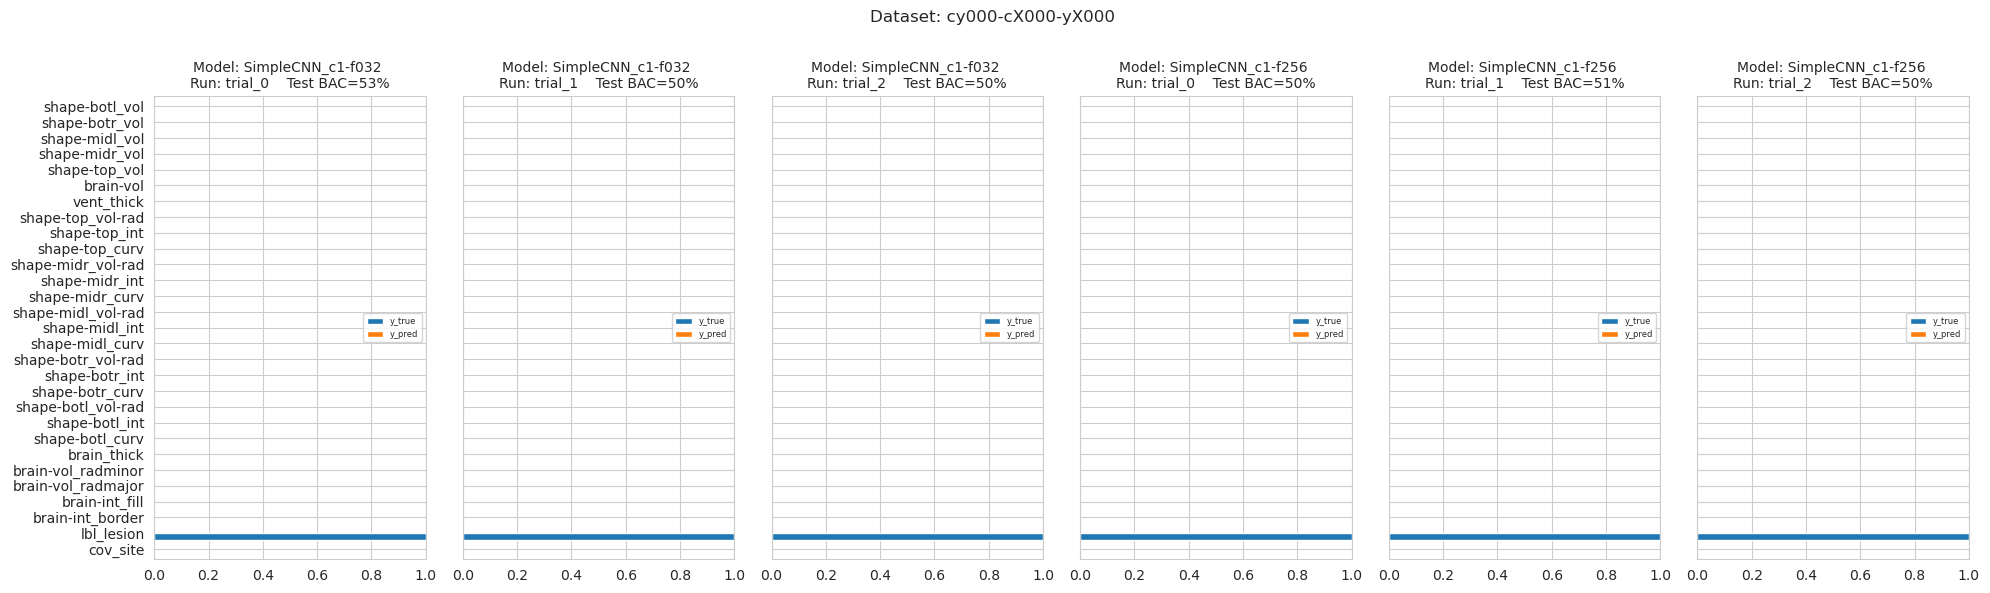

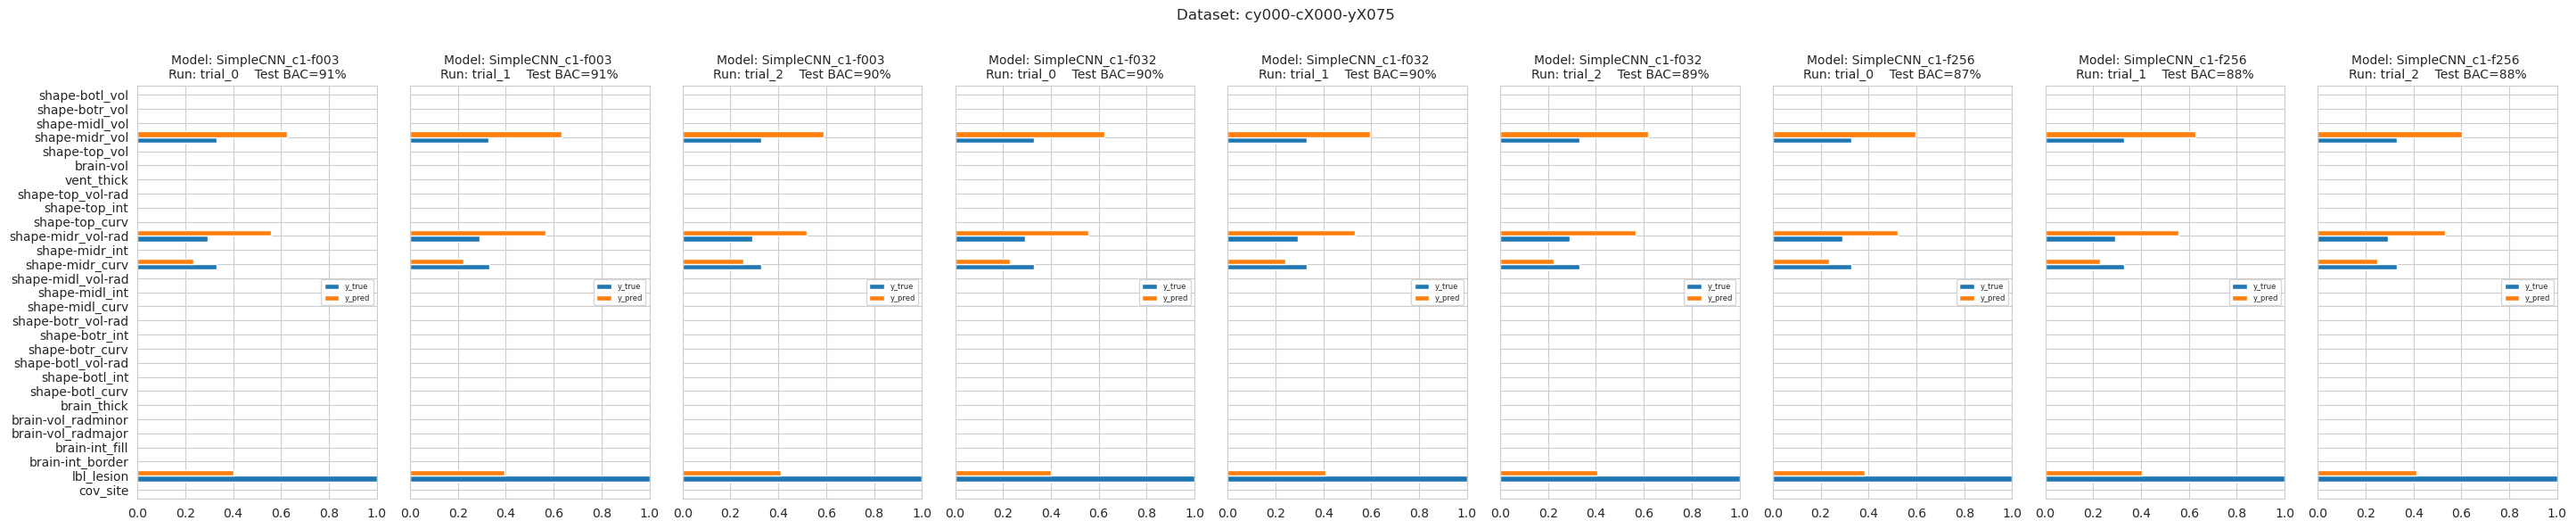

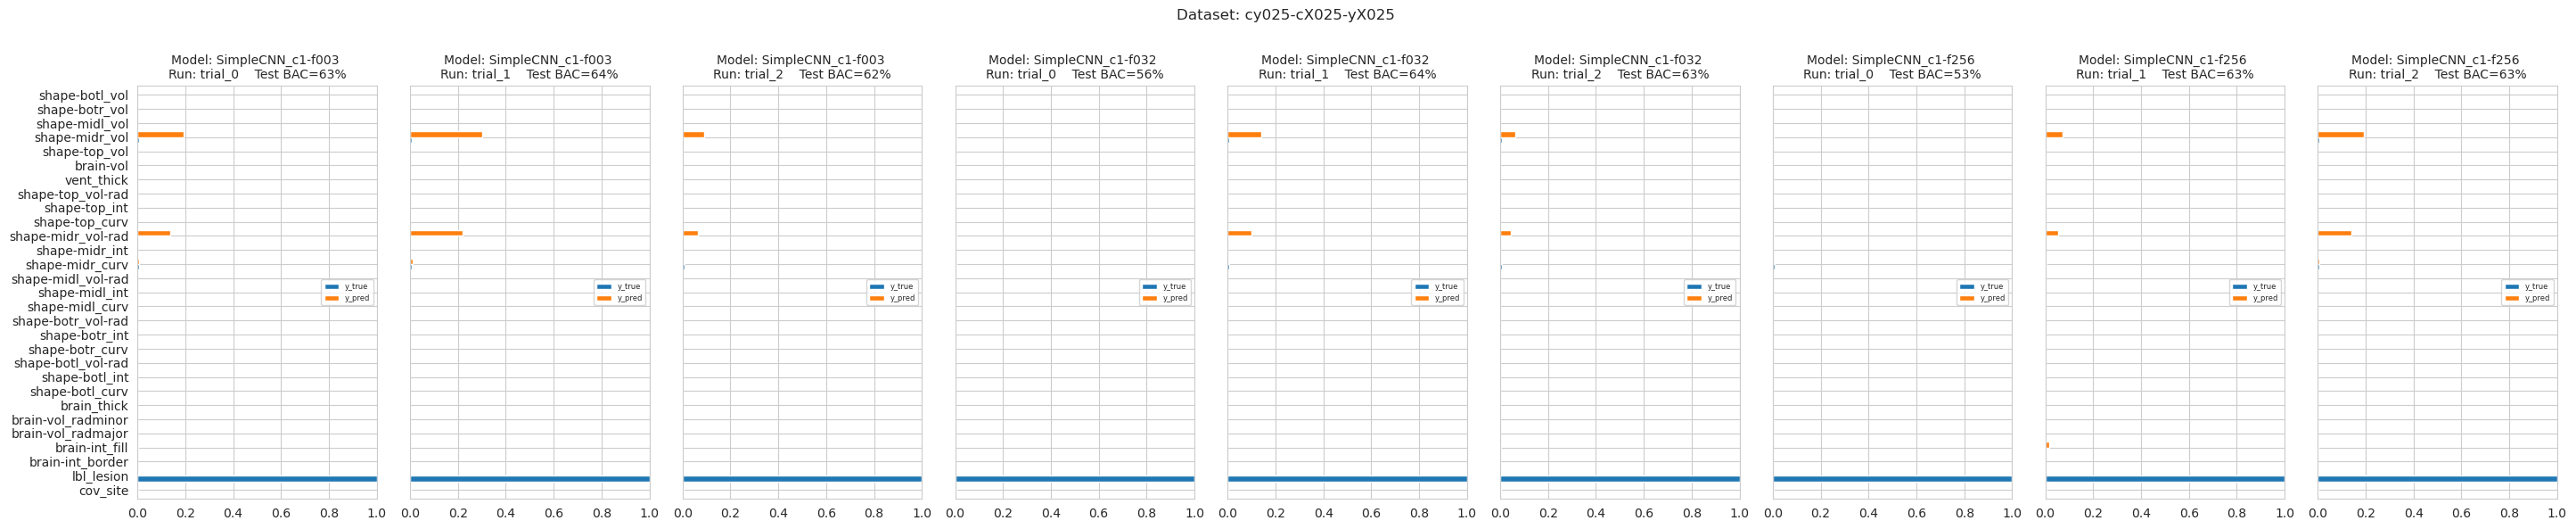

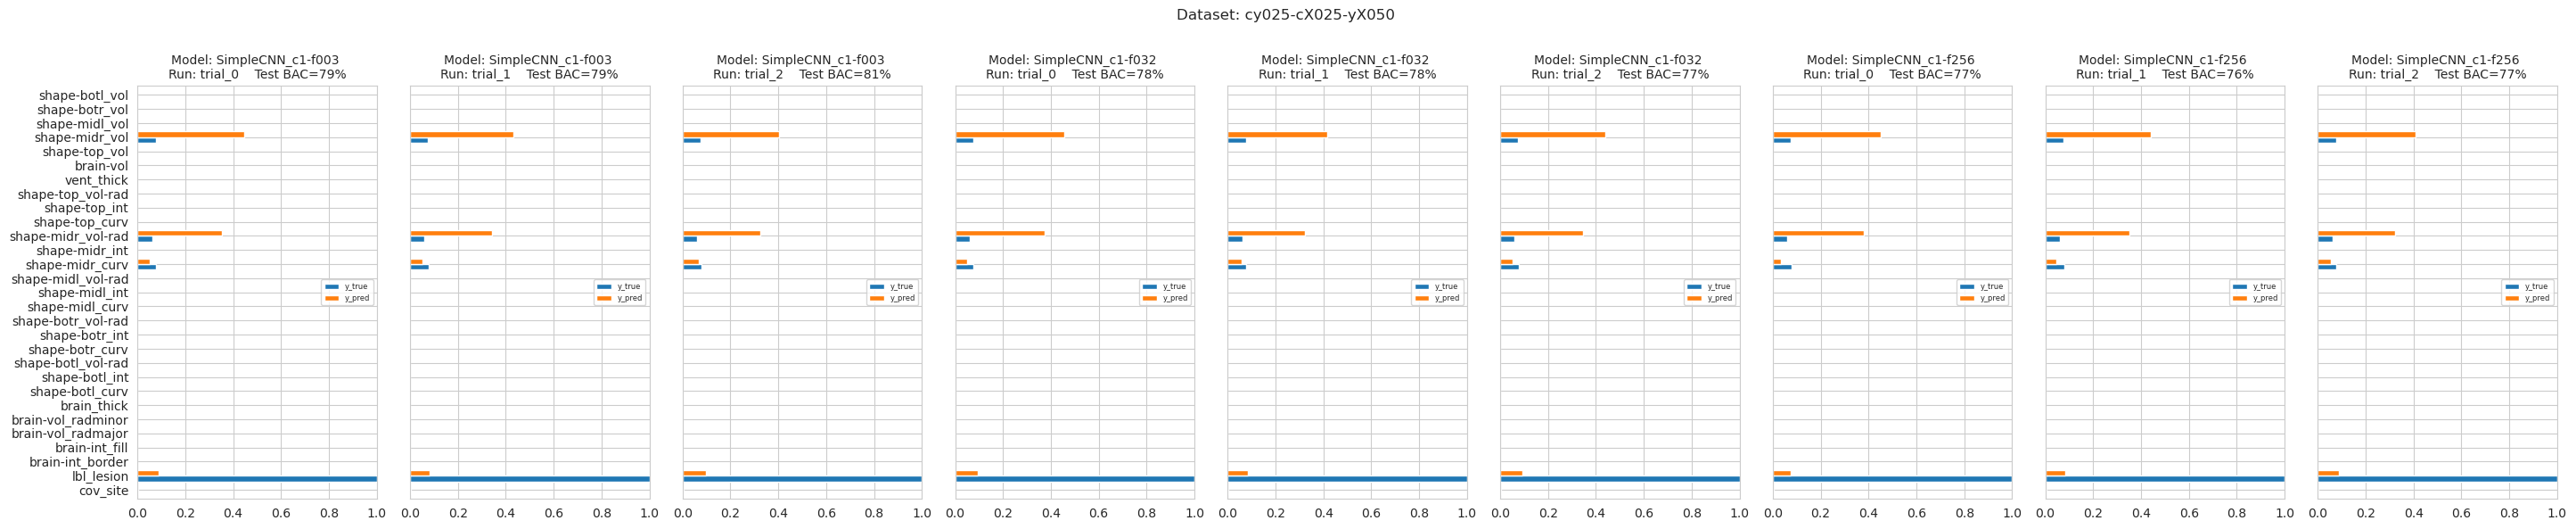

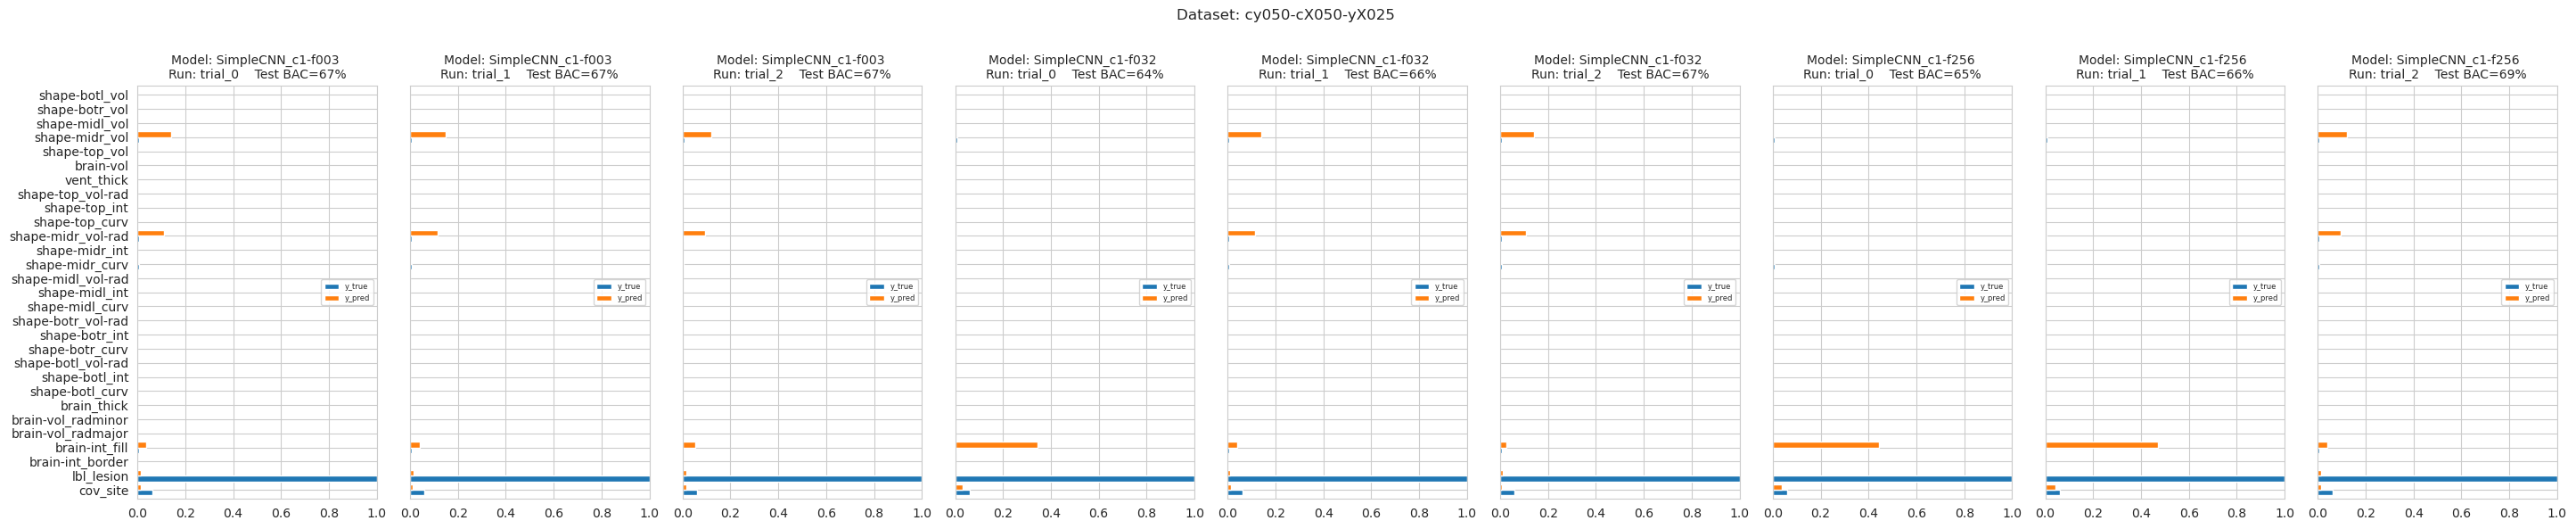

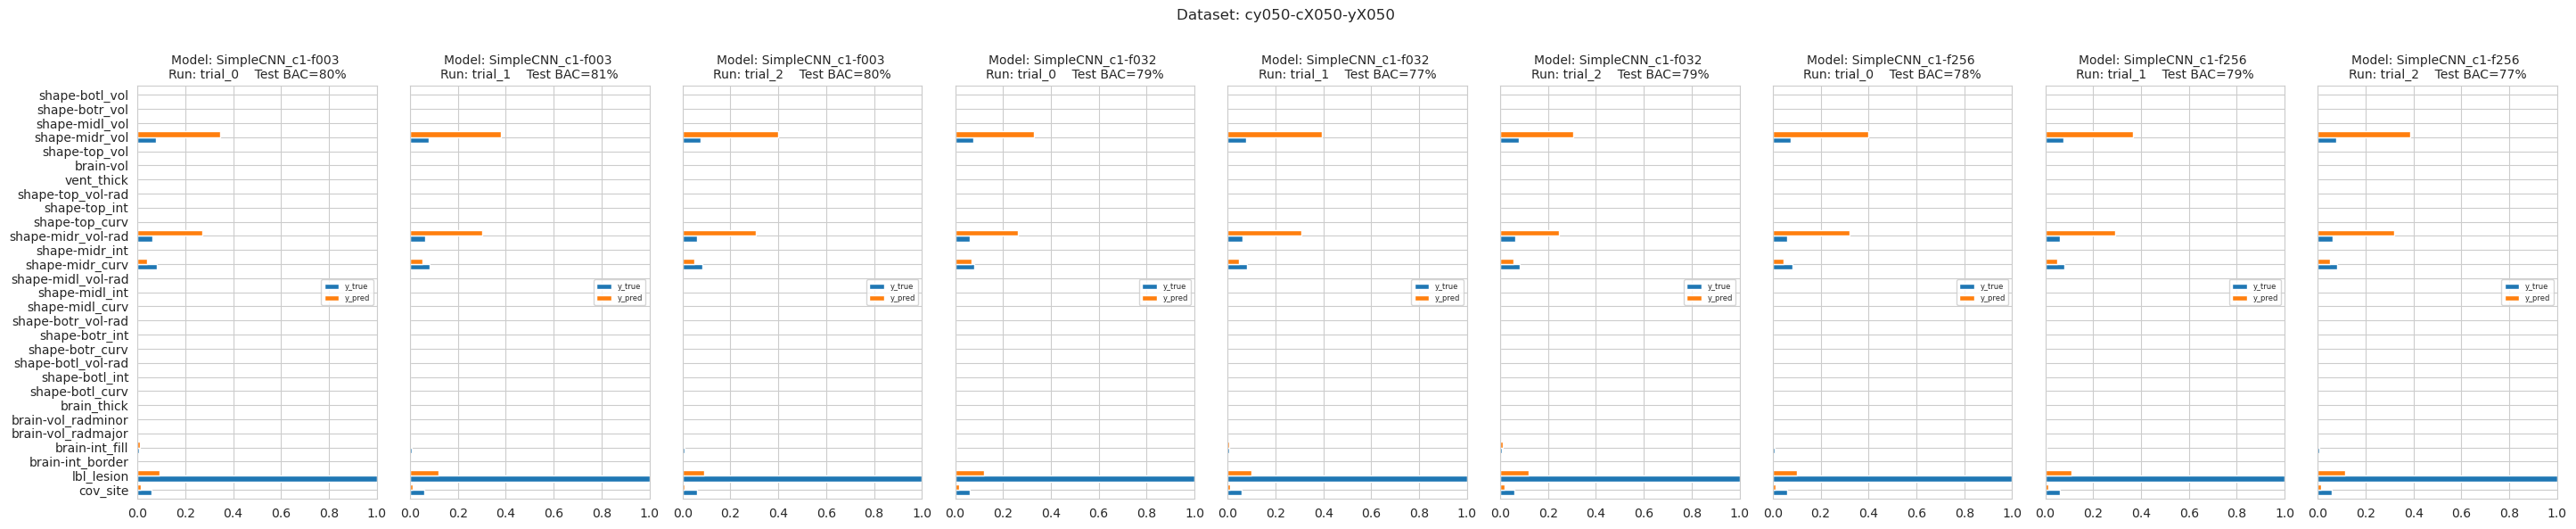

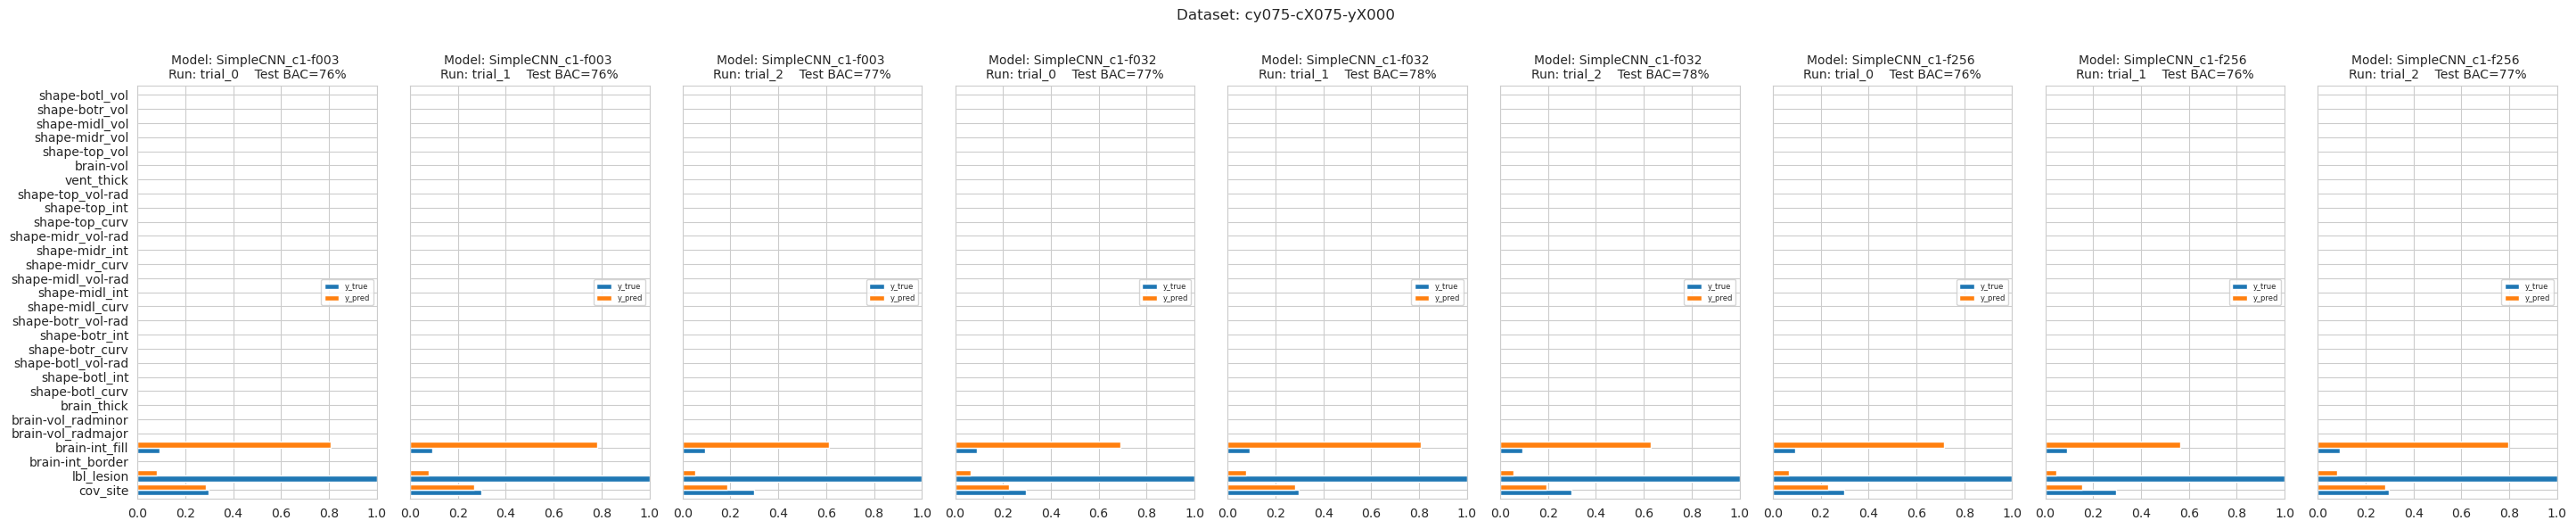

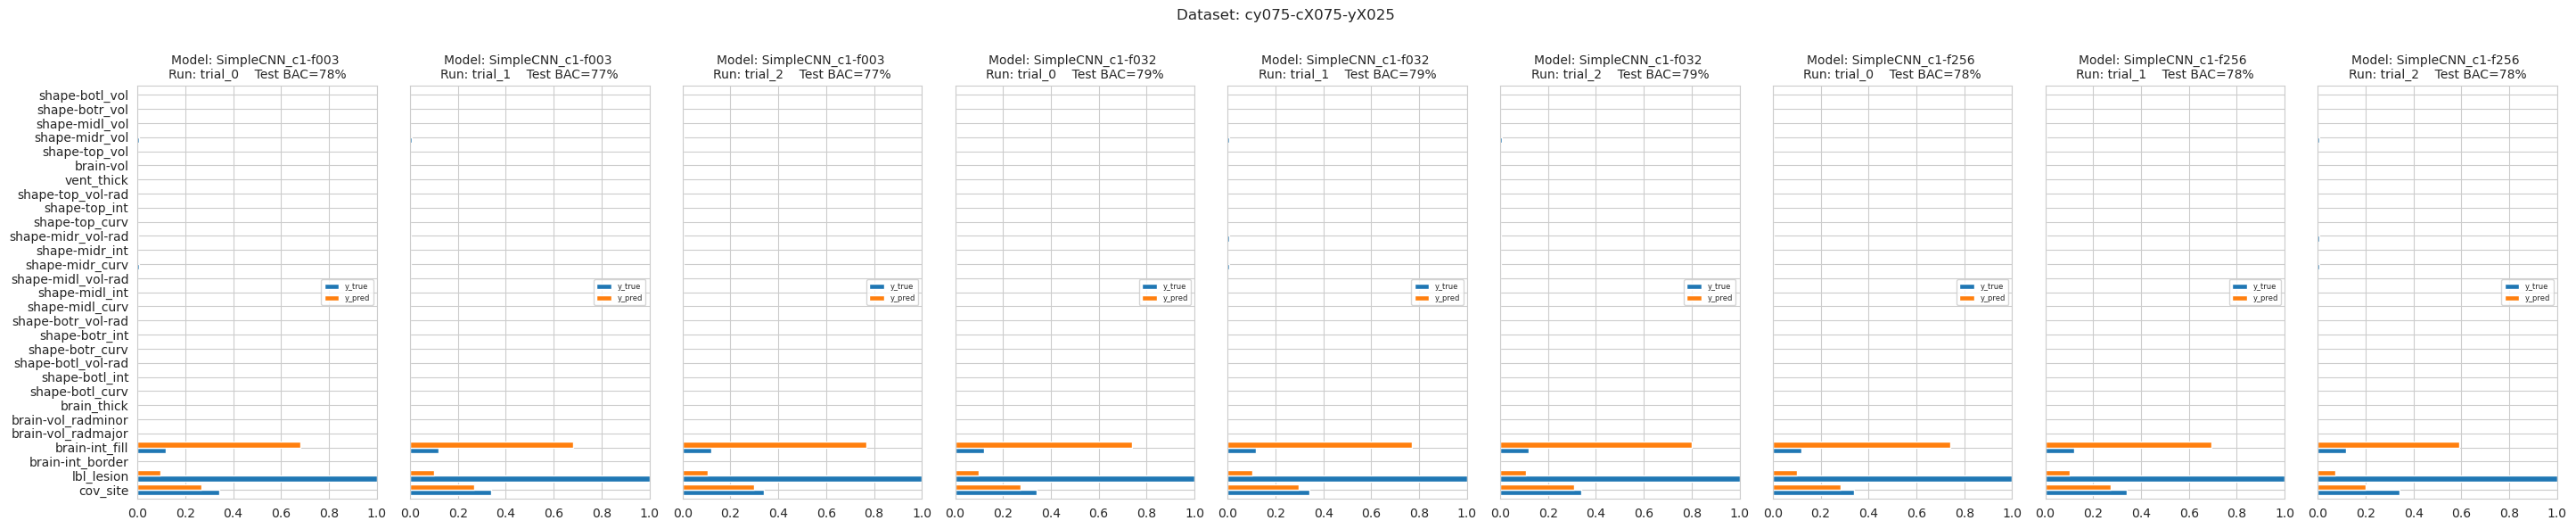

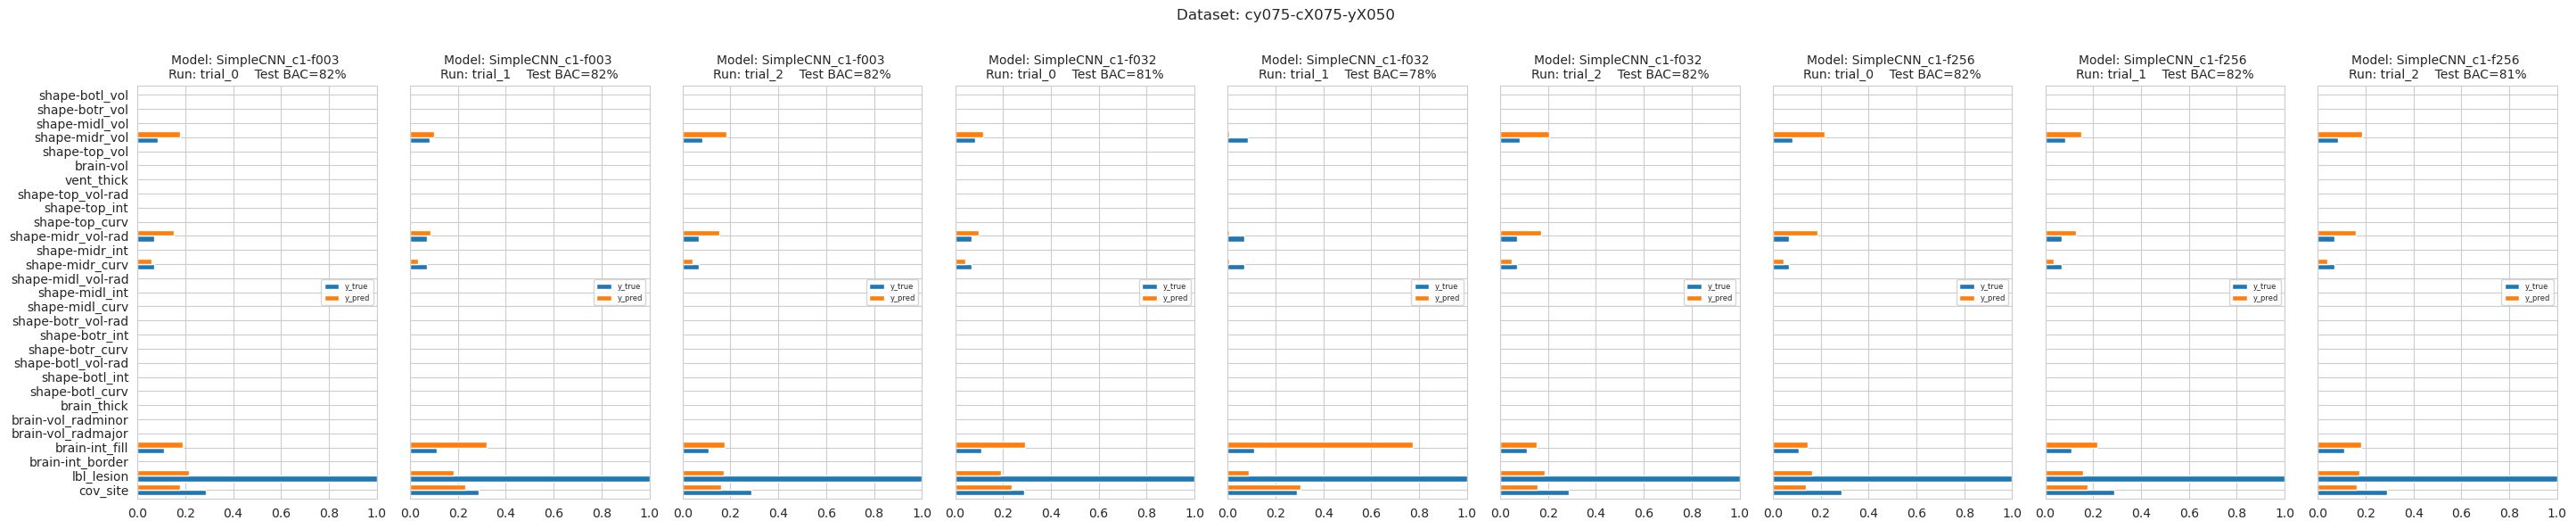

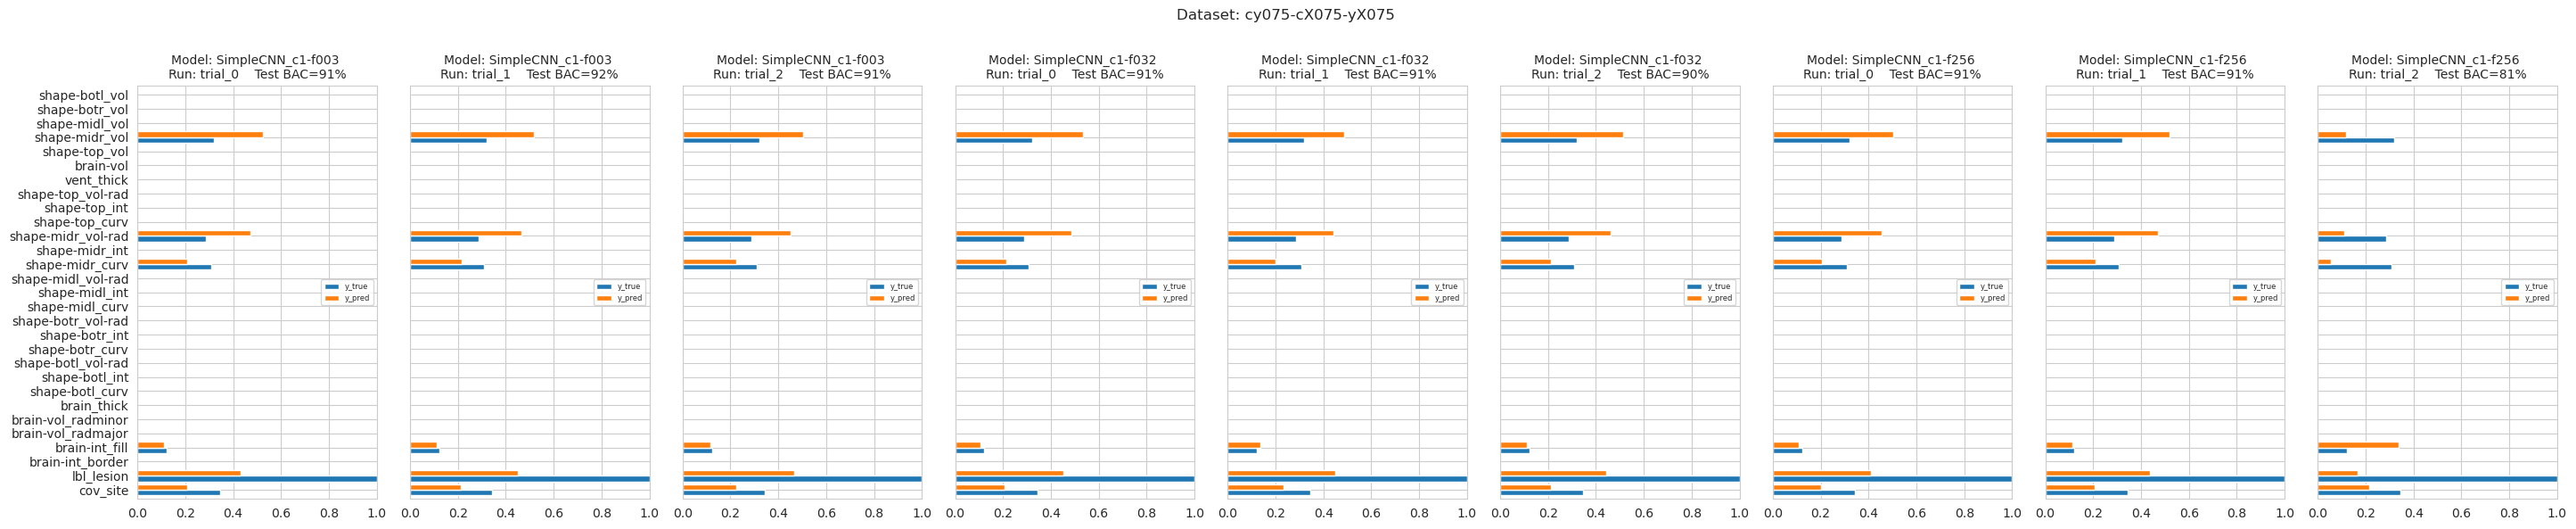

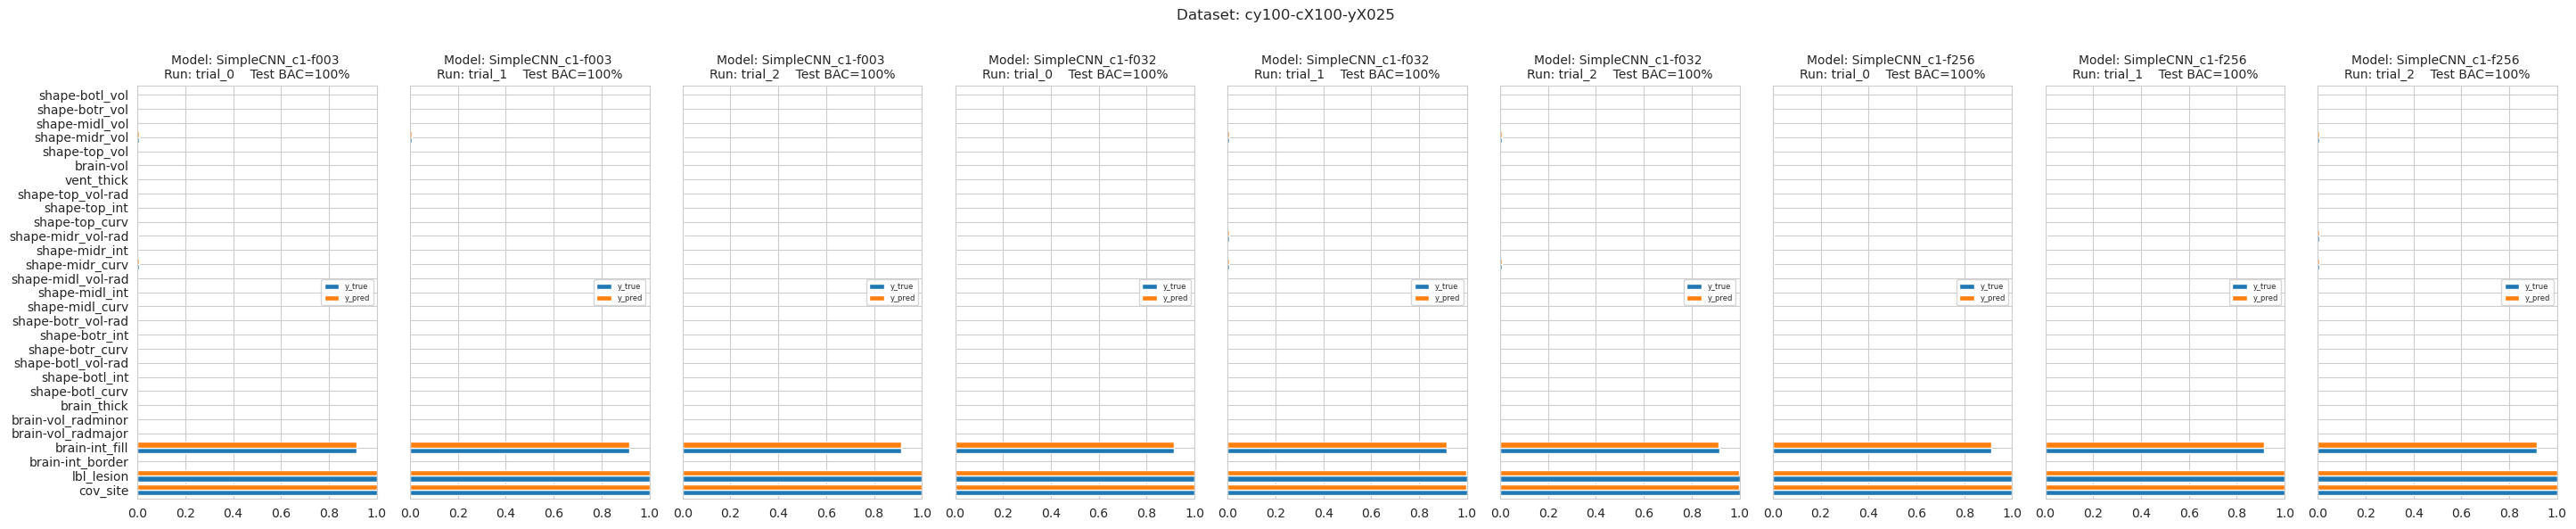

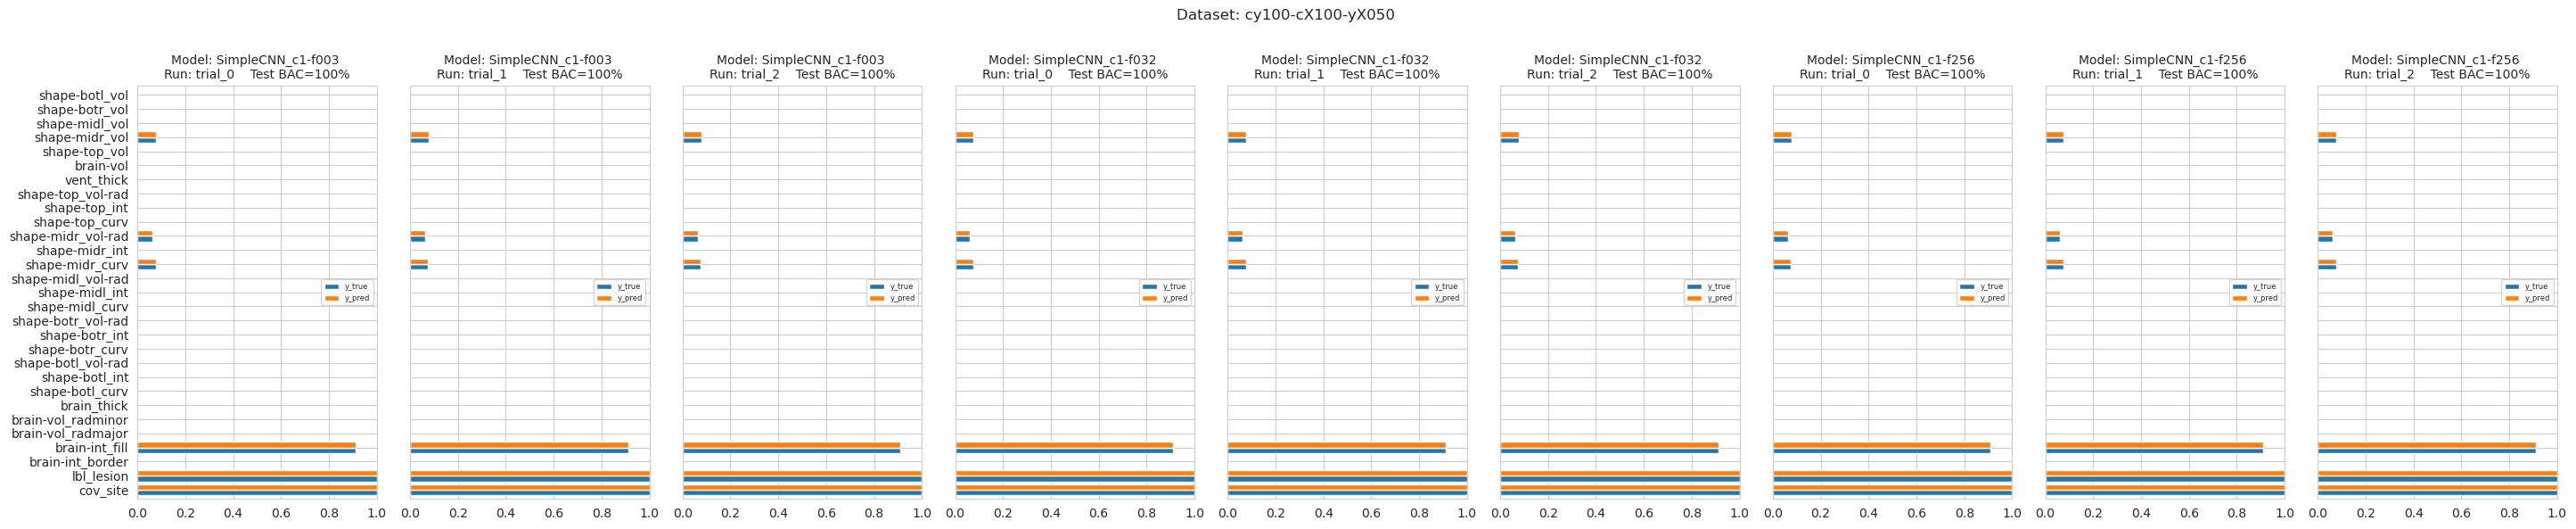

In [18]:
N_COMPONENTS = 3 


for dataset in unique_datasets:

    logs_subset = [log for log in logs if (log[0]==dataset)]
    if len(logs_subset)==0: continue

    fig, axes = plt.subplots(1, len(logs_subset), 
                            sharex=True, sharey=True, 
                            figsize=(2+3*len(logs_subset), 6))
    axes = axes.flatten()
    fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

    for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):
        # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

        # (1) load the confounds table
        df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
        # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

        # make the table values numerical using the DeepRepVizBackend
        drv = DeepRepVizBackend(conf_table=df_attrs, 
                                ID_col='subjectID', label_col='lbl_lesion', 
                                best_ckpt_by="test_loss")
        df_attrs = drv.df_conf
        # reorder to match the IDs of the model results and the confound table
        df_attrs = df_attrs.loc[log['IDs']]

        # (2) select the subset of covariates to compute the metrics
        conf_subset =  df_attrs.columns  # ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
        
        # (3) Compute the metric and populate it in a table
        df_scores = pd.DataFrame(index=['y_true','y_pred'], columns=conf_subset)

        assert np.all(log['IDs'] == df_attrs.index.values), "IDs do not match between the confound table and the model results."
        for y_name, y in [('y_true', log['y']), ('y_pred', log['y_pred']>0.5)]:
            for conf in conf_subset:
                conf_var = df_attrs[conf].values
                df_scores.at[y_name, conf] = compute_dcor_sq(y.astype(float), conf_var.astype(float))


        df_scores.T.plot.barh(ax=ax, width=0.8)
        ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
        ax.legend(loc='center right', prop={'size': 6})
        
        # if xlim is very low then set it to atleast [0,0.5]
        if ax.get_xlim()[1] < 0.5:
            ax.set_xlim(0, 0.5)
        else:
            ax.set_xlim(0, 1.)

    plt.tight_layout()
    plt.show()

### PCA ($H^{(l-1)}, c$)

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def compute_pca(X, n_components=0.9):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply PCA and print the list of PC components that explain 90% of the variance
    pca = PCA(n_components=n_components)
    X_ica = pca.fit_transform(X)
    return X_ica, pca

In [20]:
if RUN_PCA:
    N_COMPONENTS = 3 


    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        if len(logs_subset)==0: continue

        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):

            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            
            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")
            X_pca, pca = compute_pca(log['act'], n_components=N_COMPONENTS)
            # for 5 variables in the metadata table compute the correlation with the top PCs
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"PC{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

            for i in range(N_COMPONENTS):
                for conf in conf_subset:
                    conf_var = df_attrs[conf][log['IDs']]
                    df_scores.at[f"PC{i}", conf] = compute_dcor_sq(X_pca[:,i], conf_var.astype(float))

            # add the explained variance of each PC in the legend info
            def append_r2(pc):
                i = int(pc.replace('PC', ''))
                return "PC{} ($R^2={:.0f}$%)".format(i, pca.explained_variance_ratio_[i]*100)
            df_scores.index = pd.Series(df_scores.index).apply(append_r2)
            # print("Number of components with 90% variance: ", pca.n_components_)
            # print("Eigen values: ", pca.explained_variance_)

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})
            
            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)

        plt.tight_layout()
        plt.show()

### Apply ICA

> ICA is an algorithm that finds directions in the feature space corresponding to projections with high non-Gaussianity. These directions need not be orthogonal in the original feature space, but they are orthogonal in the whitened feature space, in which all directions correspond to the same variance.
PCA, on the other hand, finds orthogonal directions in the raw feature space that correspond to directions accounting for maximum variance.

In [21]:
from sklearn.decomposition import FastICA

def compute_ica(X, n_components=0.99):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply ICA 
    ica = FastICA(n_components=n_components, max_iter=2000)
    X_ica = ica.fit_transform(X) 
    
    return X_ica, ica



In [22]:
if RUN_ICA:
    N_COMPONENTS=3

    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):
            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            try:
                X_pca, pca = compute_ica(log['act'], n_components=N_COMPONENTS)
            except:
                print(f"[ERROR] ICA failed to converge for {model_name} on {dataset} at run {run}. Skipping...")
                continue
            # for 5 variables in the metadata table compute the correlation with the top PCs
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"IC{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

            for i in range(N_COMPONENTS):
                for conf in conf_subset:
                    conf_var = df_attrs[conf][log['IDs']]
                    df_scores.at[f"IC{i}", conf] = compute_dcor_sq(X_pca[:,i], conf_var.astype(float))

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})

            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)
                
        plt.tight_layout()
        plt.show()

### LDA
> PCA finds the top basis axes that maximizes the variances across each basis. 
LDA is like a (supervised) PCA that maximizes the separability of a given categorical variable $y$ across each basis. 

> LDA does this by finding an axis that maximizes the across-groups mean while minimizing the in-group standard diviation.


In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSRegression

def compute_lda(X, y):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply ICA 
    if 'int' in y.dtype.str:
        lda = LinearDiscriminantAnalysis()
    else:
        lda = PLSRegression()
    lda.fit(X, y) 
    X_lda = lda.transform(X)
    
    return X_lda, lda


In [24]:
if RUN_LDA:
    N_COMPONENTS=3

    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):

            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            
            # for 5 variables in the metadata table compute the metric
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"LDA{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

            
            for conf in conf_subset:
                conf_var = df_attrs[conf][log['IDs']]
                try:
                    X_lda, lda = compute_lda(log['act'], conf_var) # (log['y_pred']>0.5)
                except Exception as e:
                    print(f"[ERROR] LDA failed to converge for {model_name} on {dataset} at run {run}. Skipping... \n{e}")
                    continue
                for i in range(X_pca.shape[-1]):
                    df_scores.at[f"LDA{i}", conf] = compute_dcor_sq(X_lda[:,i], conf_var.astype(float))

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})

            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)

        plt.tight_layout()
        plt.show()

### PLS 
> Cross decomposition algorithms (CCA and PLS) find the fundamental relations between two matrices `X` and `Y` by projecting both `X` and `Y` into a lower-dimensional subspace such that the covariance between `transformed(X)` and `transformed(Y)` is maximal.

> PLS estimators are particularly suited when the matrix of predictors has more variables than observations, and when there is multicollinearity among the features.

In [25]:
from sklearn.cross_decomposition import CCA, PLSCanonical

def compute_pls(X, y, n_components=2):
    # apply CCA on H(l-1) vs [lbl_lesion, cov_site]
    pls = PLSCanonical(n_components=n_components, 
              scale=True, 
              max_iter=2000)
    X_pls, y_pls = pls.fit_transform(X, y)
    
    return X_pls, pls 

In [26]:
if RUN_CCA:
    N_COMPONENTS=2

    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):

            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            
            # for 5 variables in the metadata table compute the metric
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"CCA{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

            ### (2) Compute CCA
            df_scores_lbl_cov = df_attrs.copy()#[['lbl_lesion', 'cov_site',]]
            try:
                X_cca, cca = compute_pls(log['act'], df_scores_lbl_cov, n_components=N_COMPONENTS) 
            except Exception as e:
                print(f"[ERROR] CCA failed to converge for {model_name} on {dataset} at run {run}. Skipping... \n{e}")
                continue
            
            for conf in conf_subset:
                conf_var = df_attrs[conf][log['IDs']]
                for i in range(X_cca.shape[-1]):
                    df_scores.at[f"CCA{i}", conf] = compute_dcor_sq(X_cca[:,i], 
                                                                    conf_var.astype(float))

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})
           
            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)

        plt.tight_layout()
        plt.show()

In [27]:
# if RUN_CCA:
#     cca = CCA(n_components=2, 
#               scale=True, 
#               max_iter=2000)
#     X_cca, y_cca = cca.fit_transform(log['act'], df_scores_lbl_cov)

#     # X_cca.shape, y_cca.shape
#     X_data = pd.DataFrame(X_cca, columns=['H0', 'H1'])#, var_name='features', value_name='feature_values')
#     y_data = pd.DataFrame(y_cca, columns=['c0', 'c1'])#, var_name='covariates', value_name='covariate_values')
#     data = X_data.join(y_data, how='outer')


#     # Create subplots
#     fig, axes = plt.subplots(nrows=(X_cca.shape[-1]), ncols=(y_cca.shape[-1]), figsize=(5, 5))

#     # Iterate over each column in X_cca
#     for x_col in range(X_cca.shape[1]):
#         # Iterate over each column in y_cca
#         for y_col in range(y_cca.shape[1]):
#             ax = axes[x_col, y_col]
#             # Create a scatter plot
#             ax.scatter(X_cca[:, x_col], y_cca[:, y_col])
#             ax.set_xlabel(f'H{x_col}')
#             ax.set_ylabel(f'c{y_col}')
#             ax.set_title(f'Relationship between H{x_col} and c{y_col}')

#     # Adjust spacing between subplots
#     plt.tight_layout()

#     # Show the plot
#     plt.show()


### CCA+ICA (ICCons)
Independant canonical concepts or ICCons

In [28]:
def compute_pls_ica(X, y, n_components=2):
    # apply CCA on H(l-1) vs [lbl_lesion, cov_site]
    pls = PLSCanonical(n_components=n_components, 
                        scale=True, 
                        algorithm='svd',
                        # algorithm='nipals', max_iter=5000, tol=0.5e-5
                        )
    X_pls, y_pls = pls.fit_transform(X, y)

    X_ica, ica = compute_ica(X_pls, n_components=n_components)
    
    return X_ica, (pls, ica)

invalid value encountered in divide


[ERROR] CCA failed to converge for SimpleCNN_c1-f256 on cy000-cX000-yX000 at run trial_0. Skipping... 
array must not contain infs or NaNs


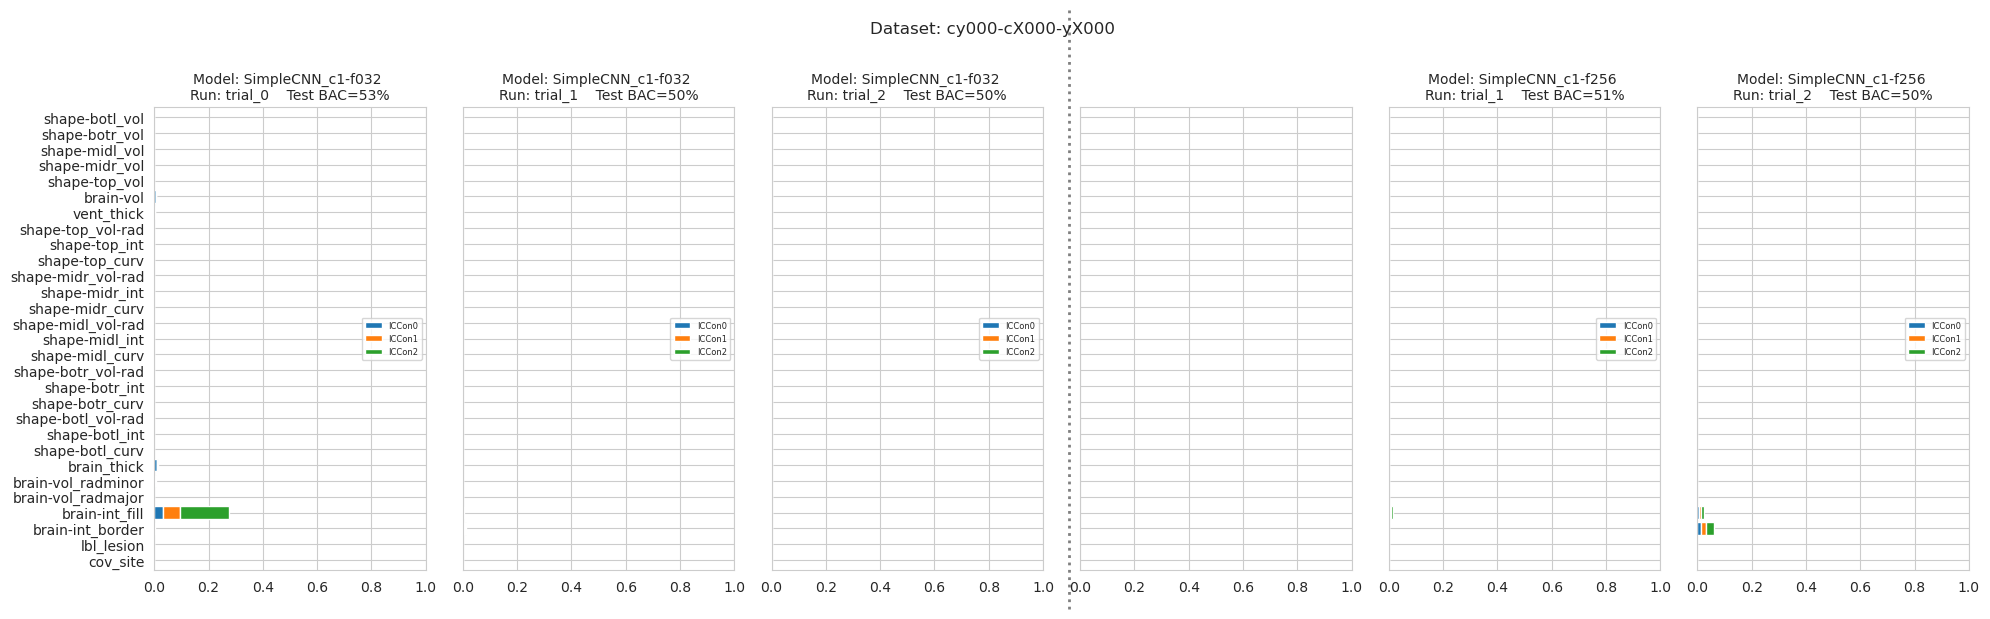

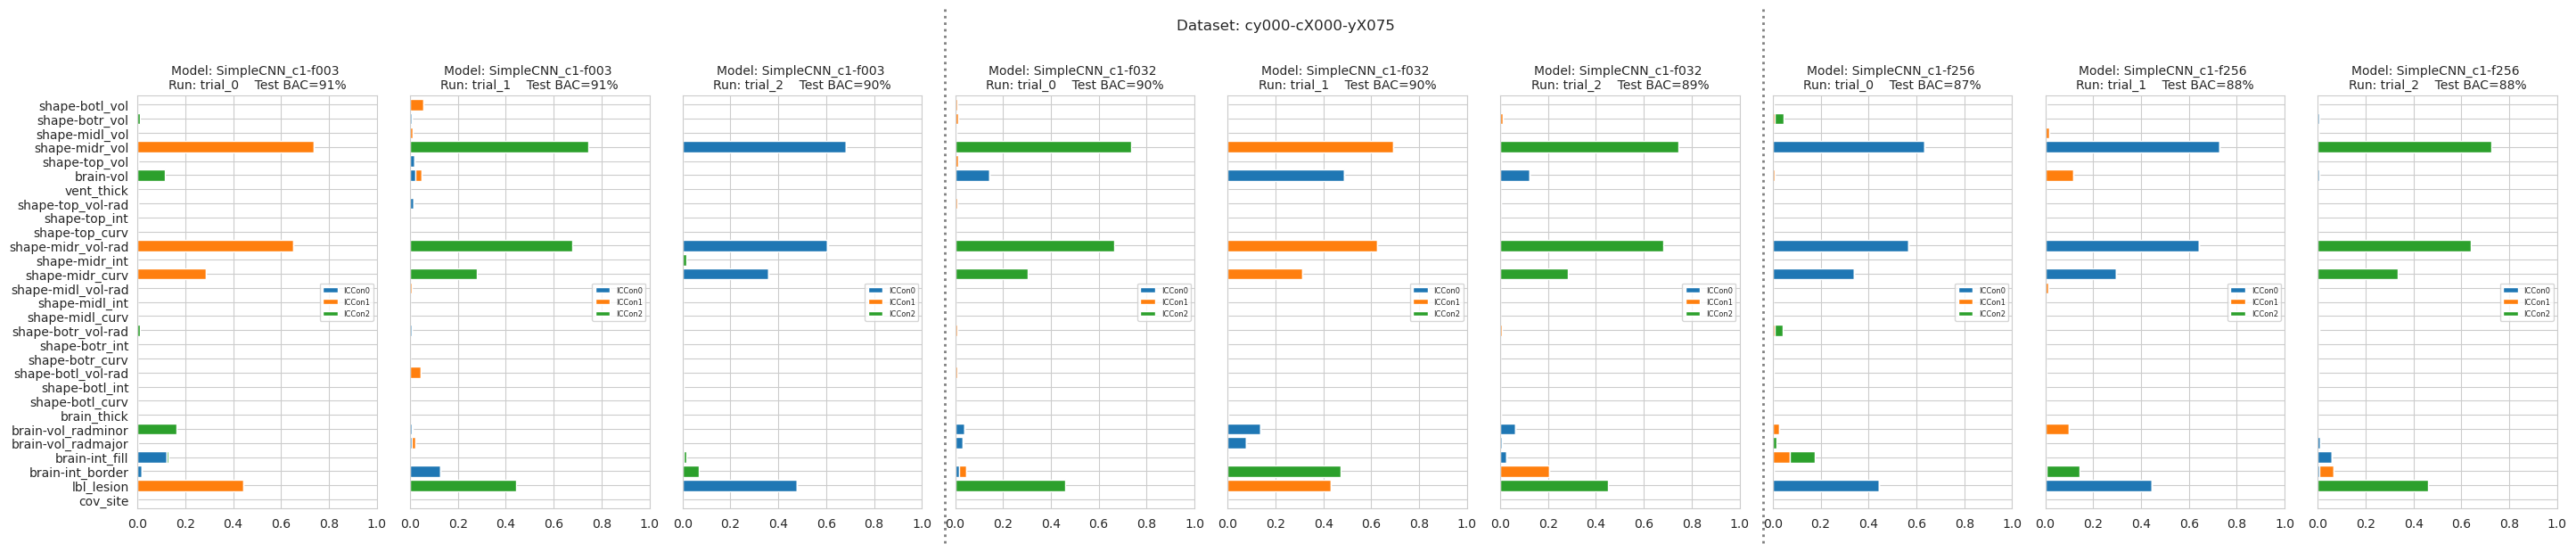

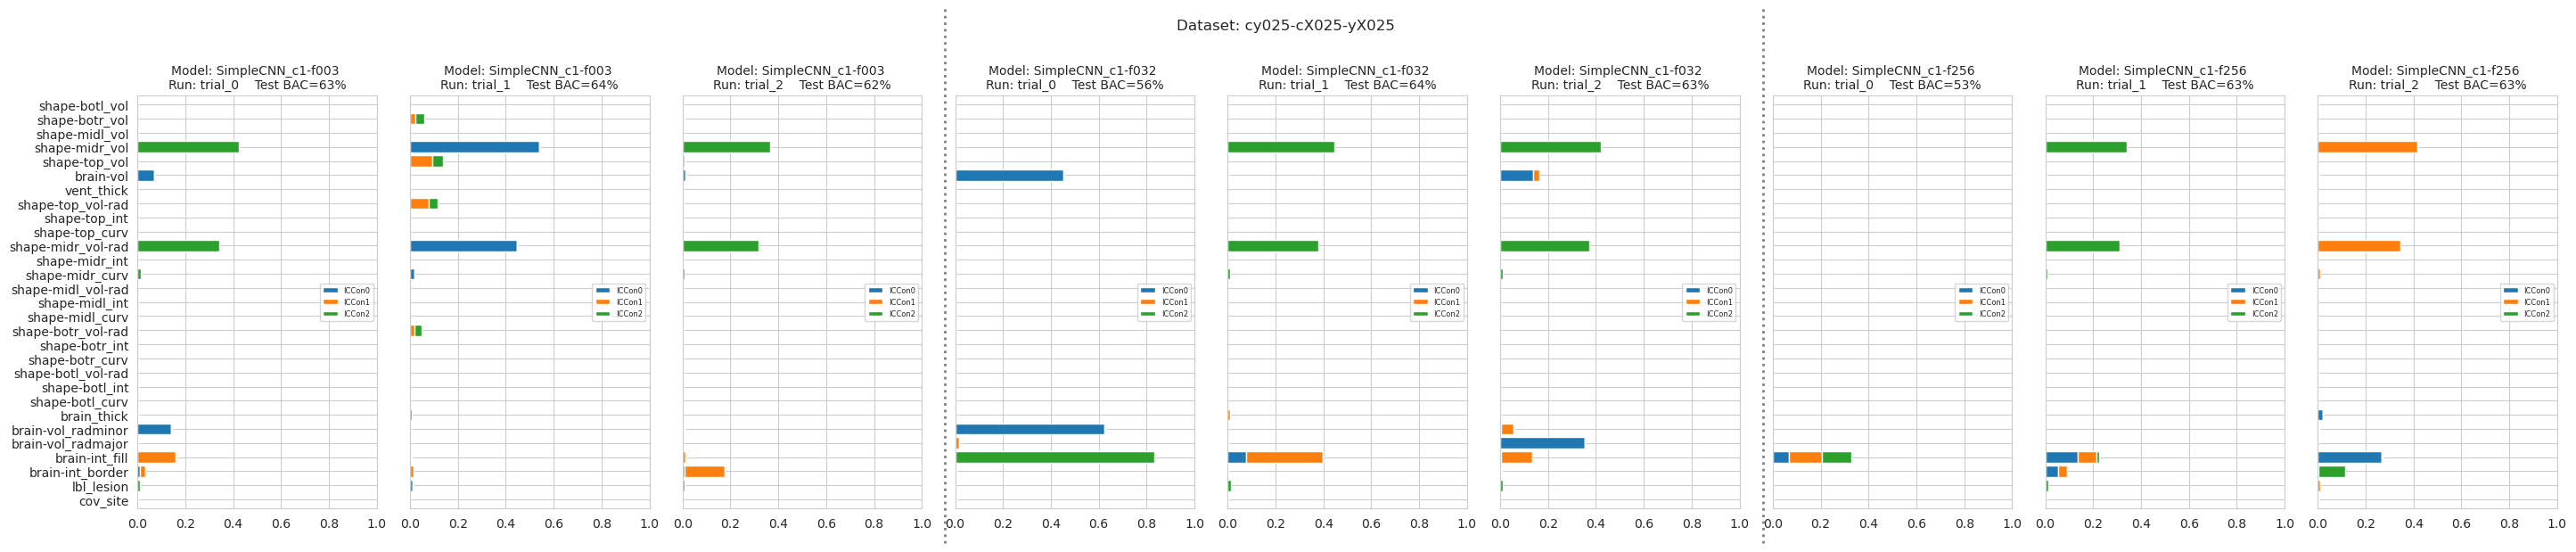

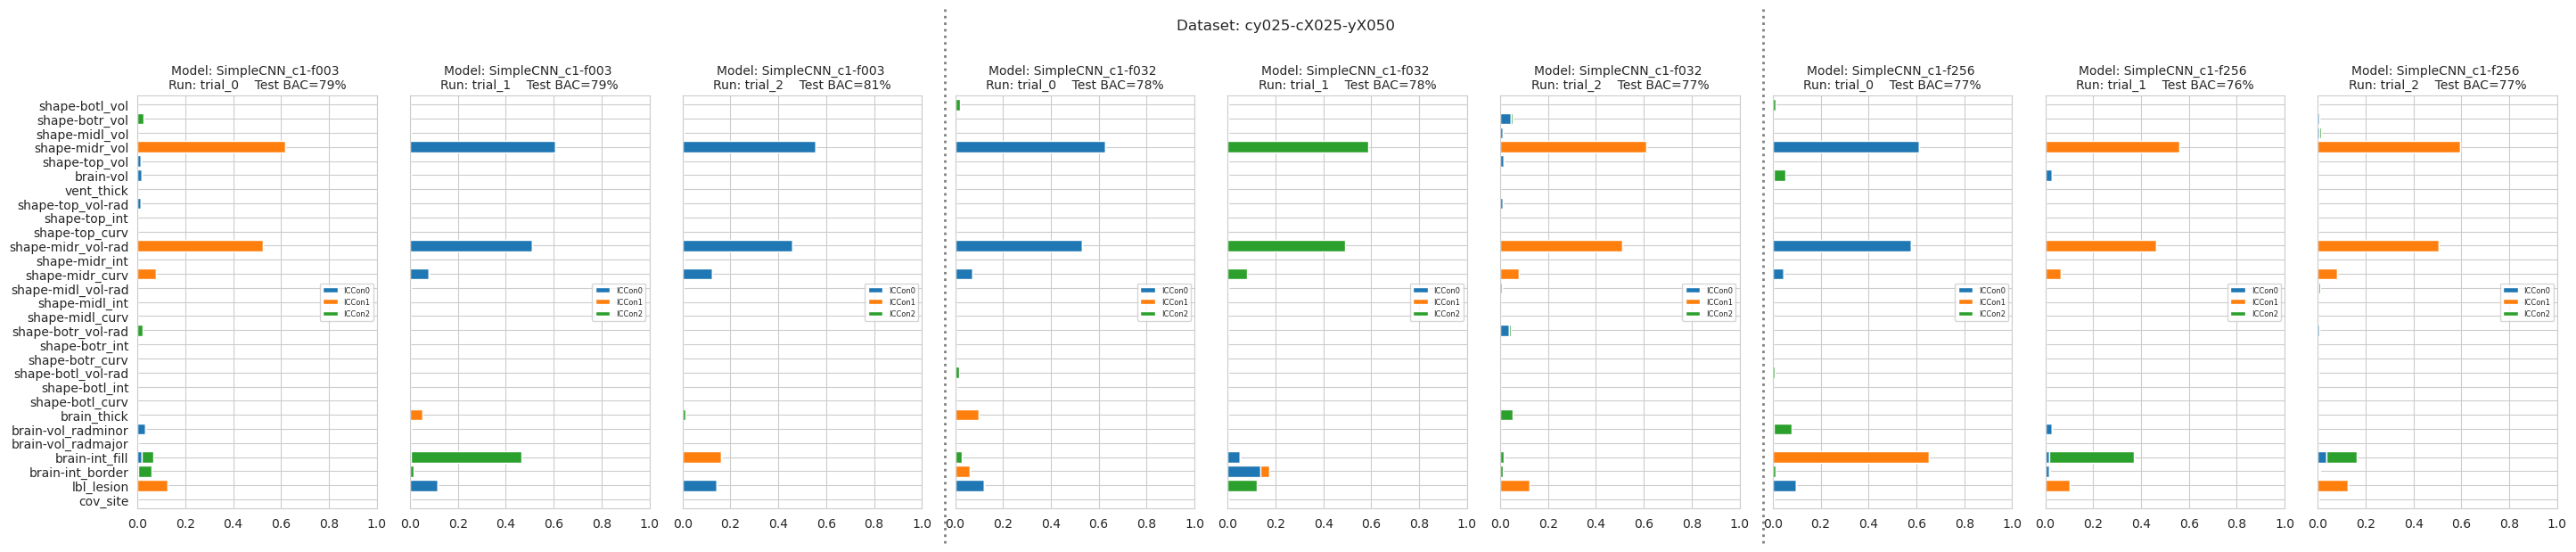

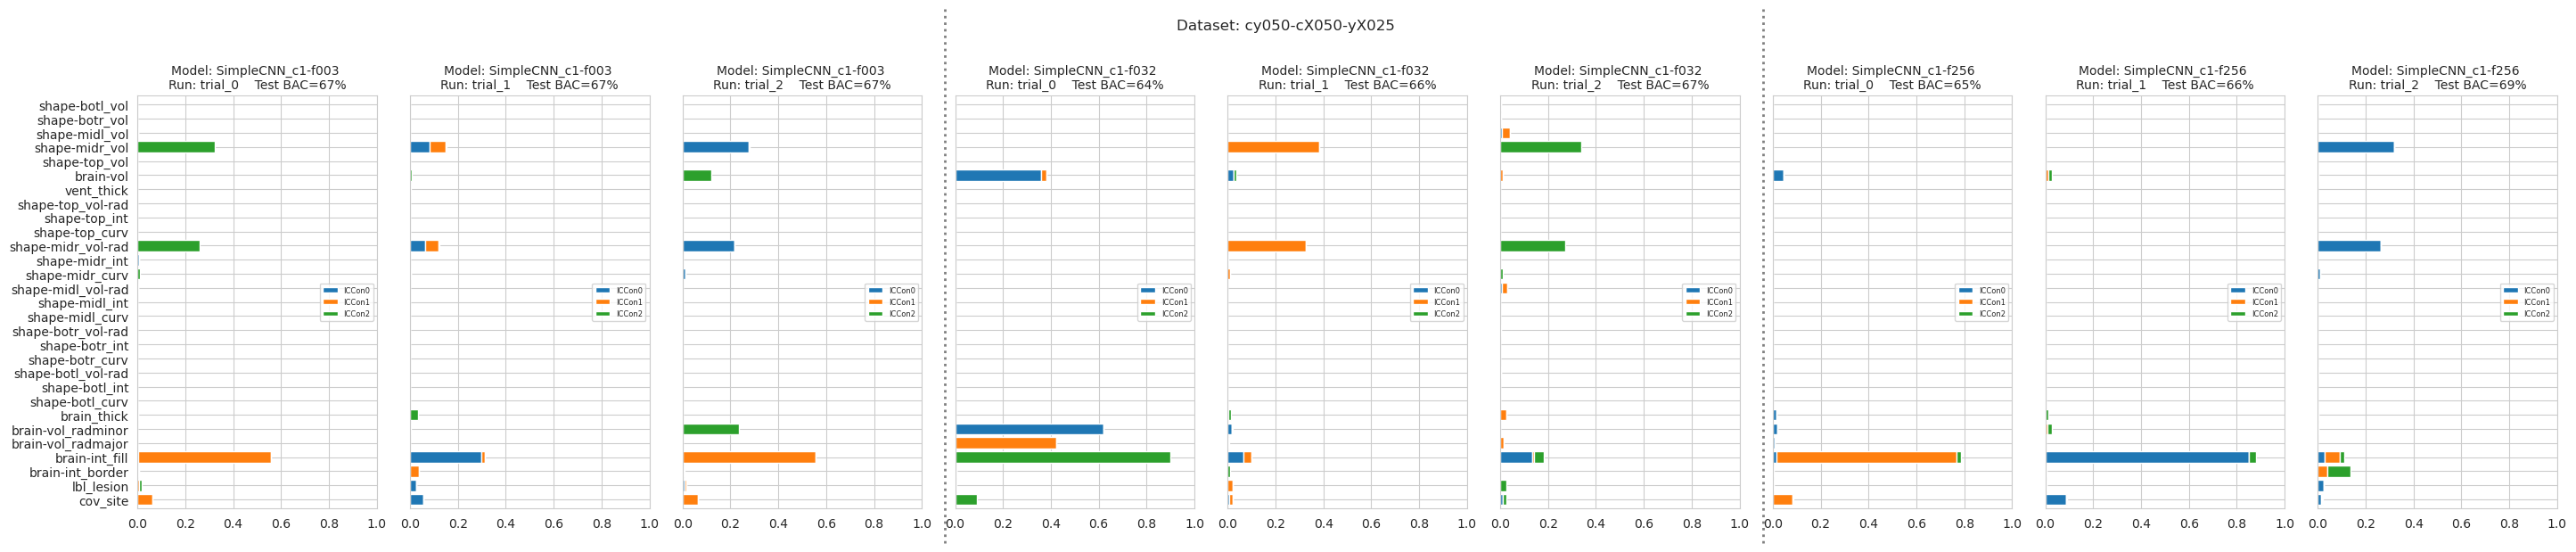

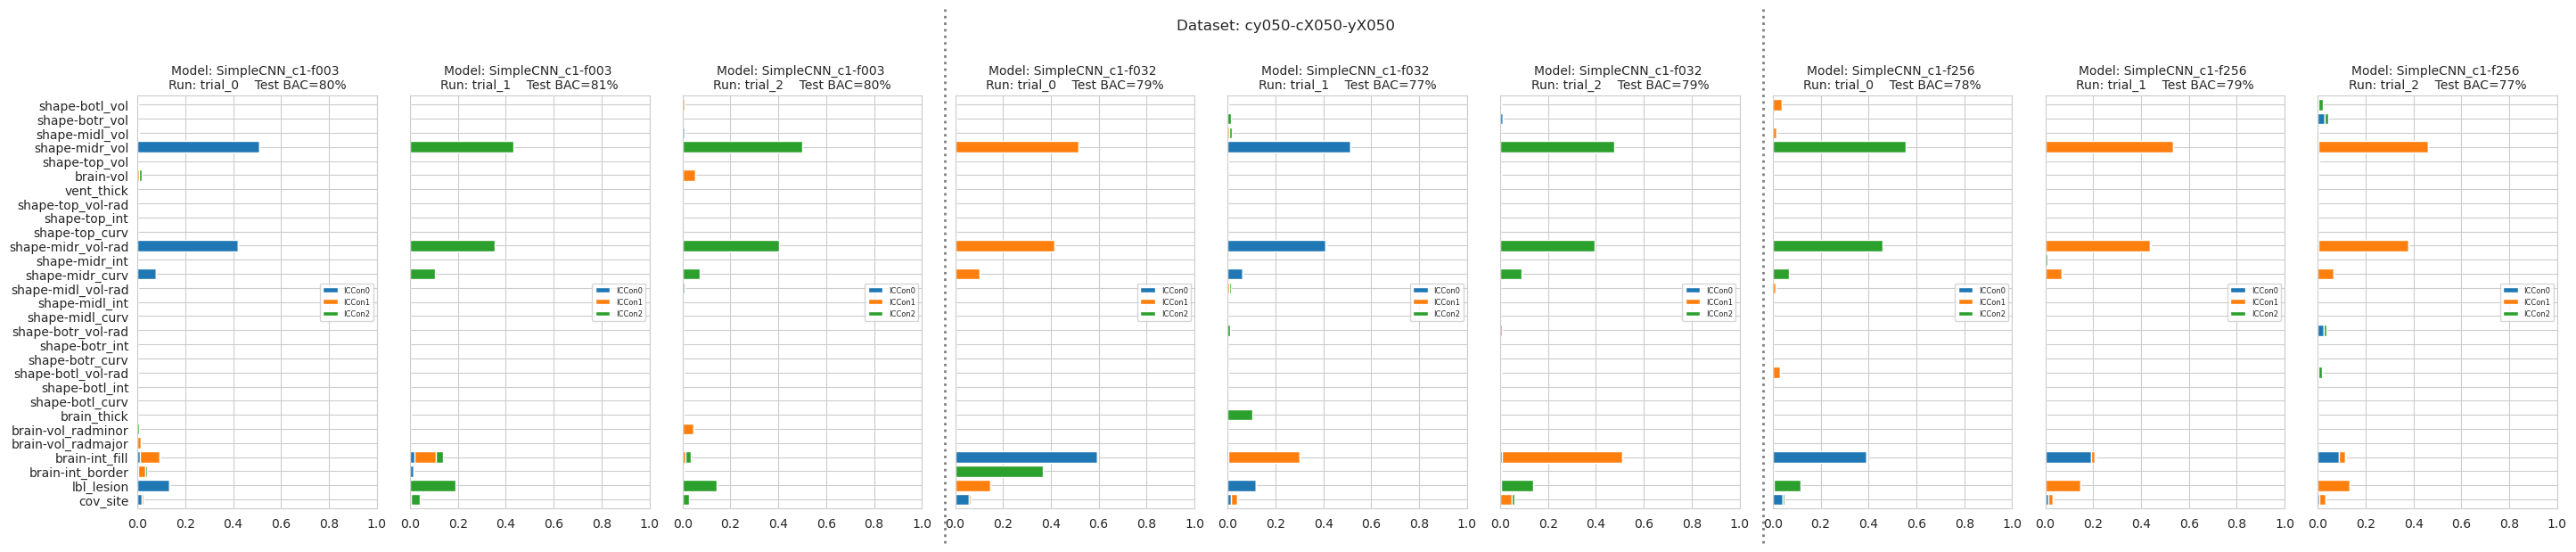

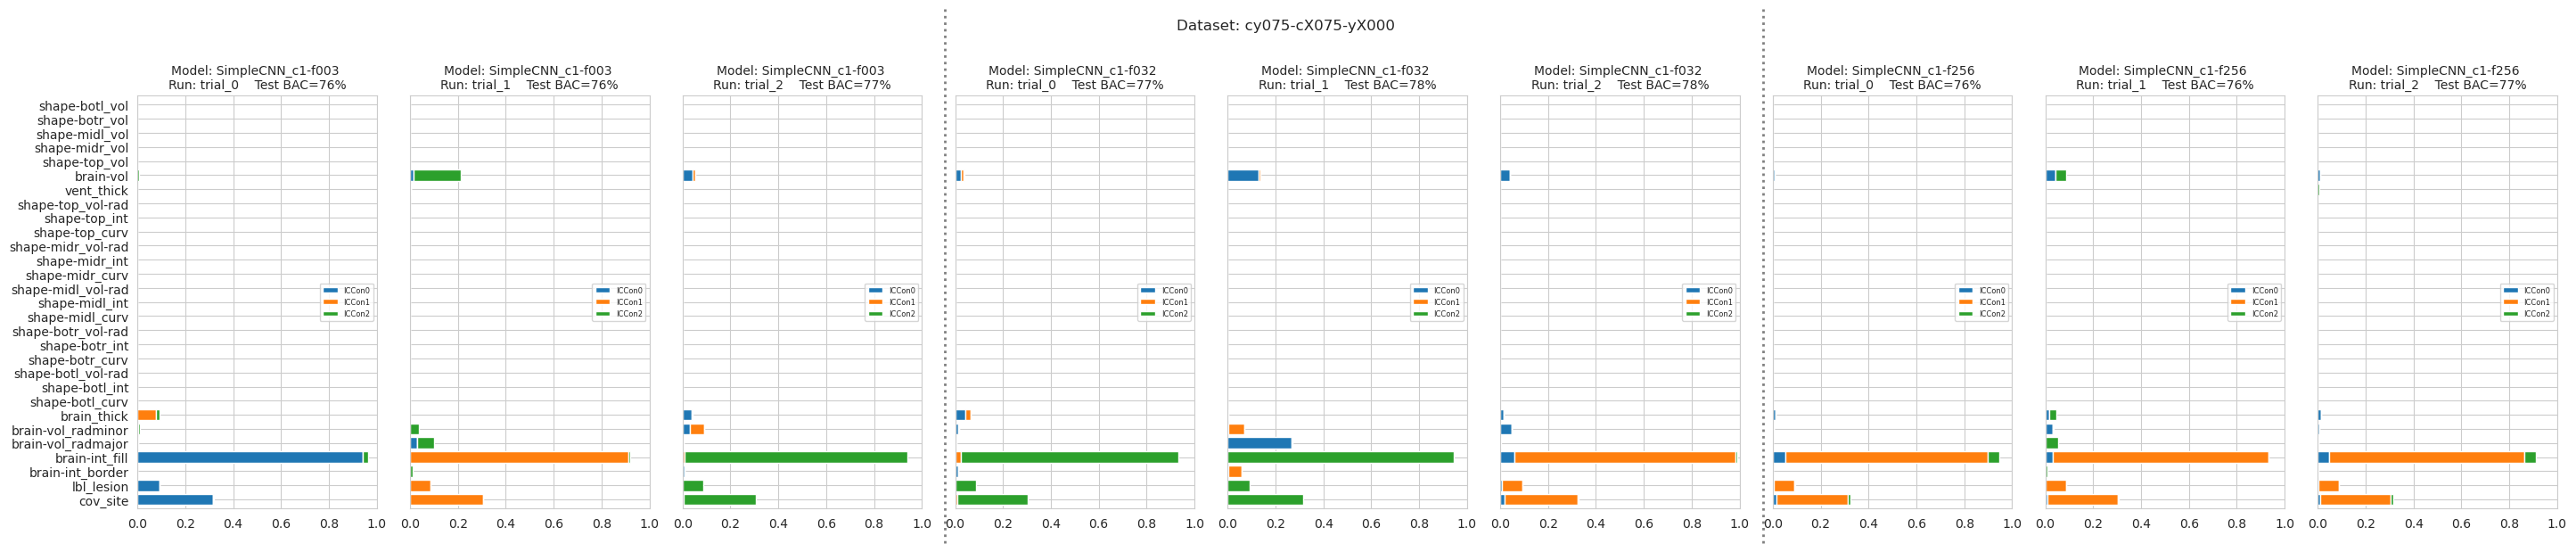

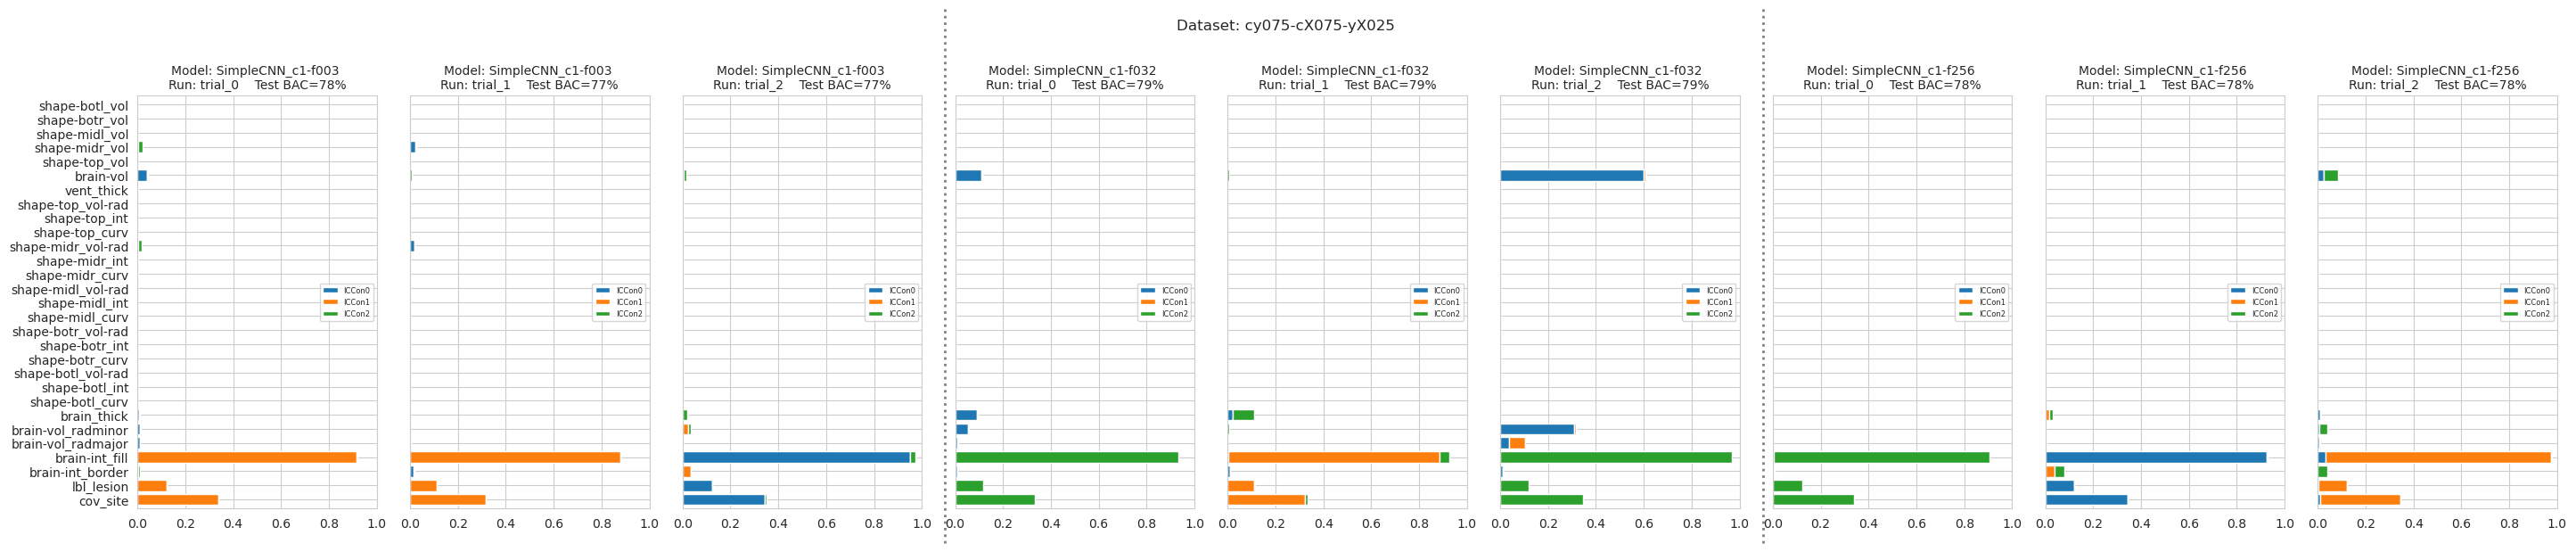

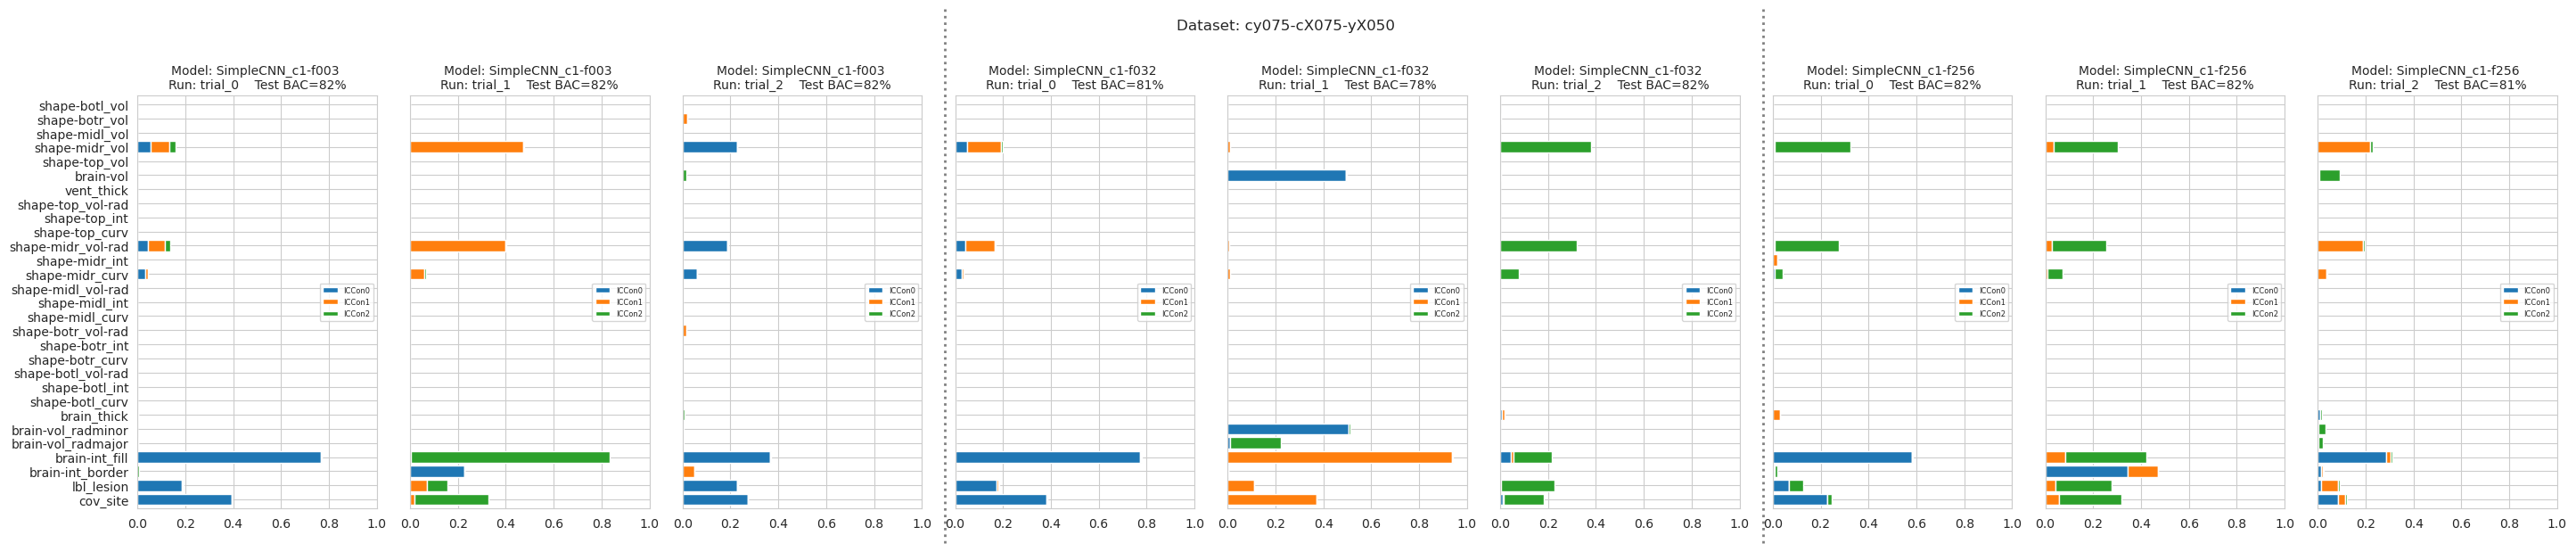

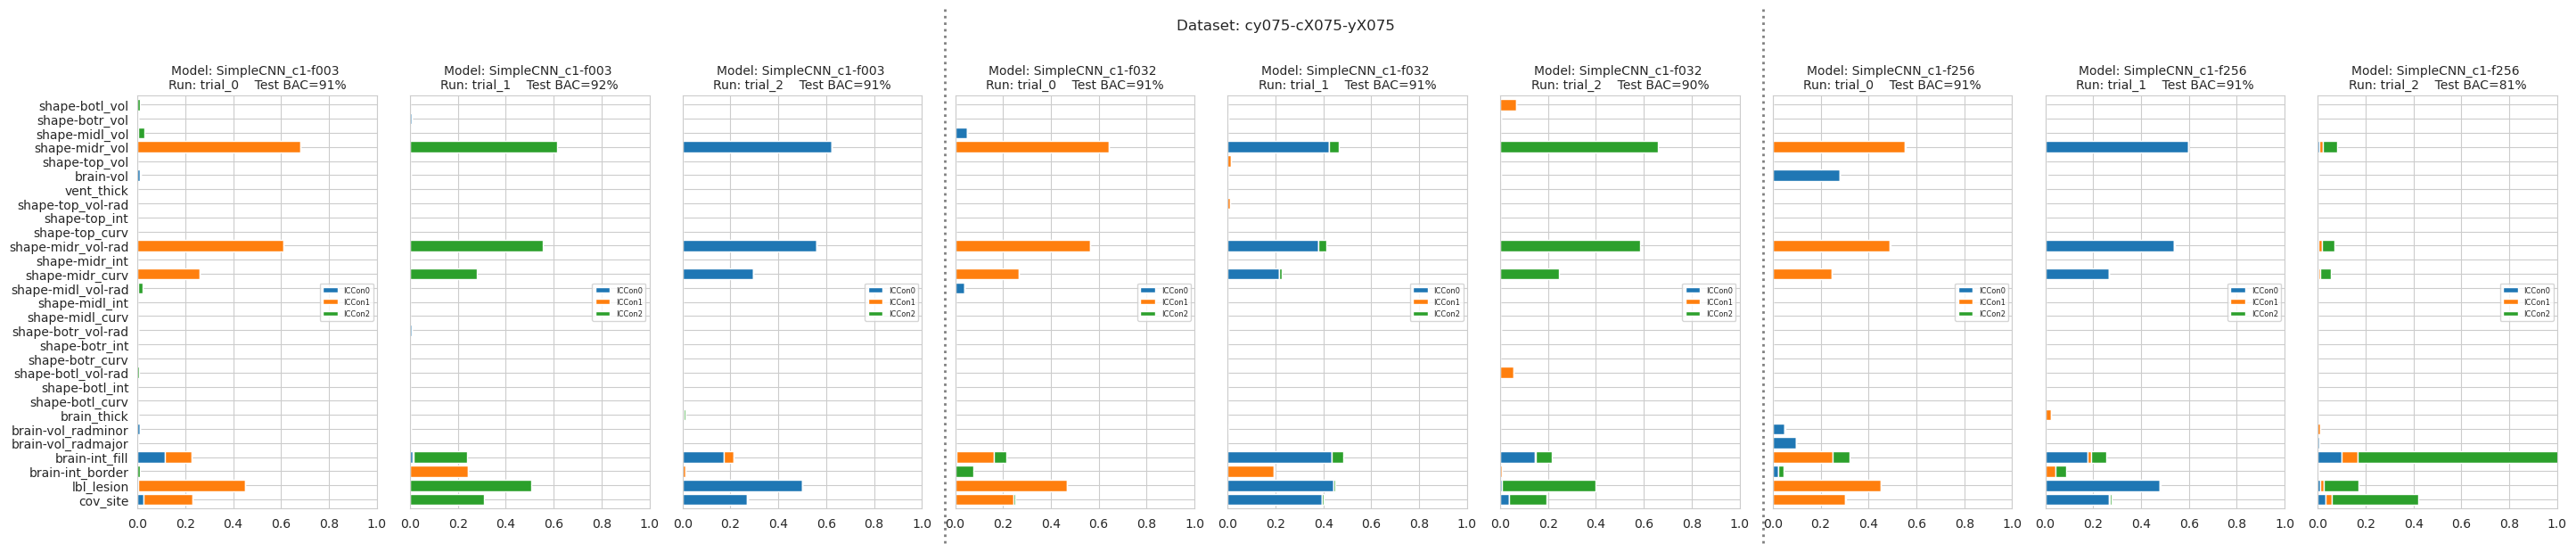

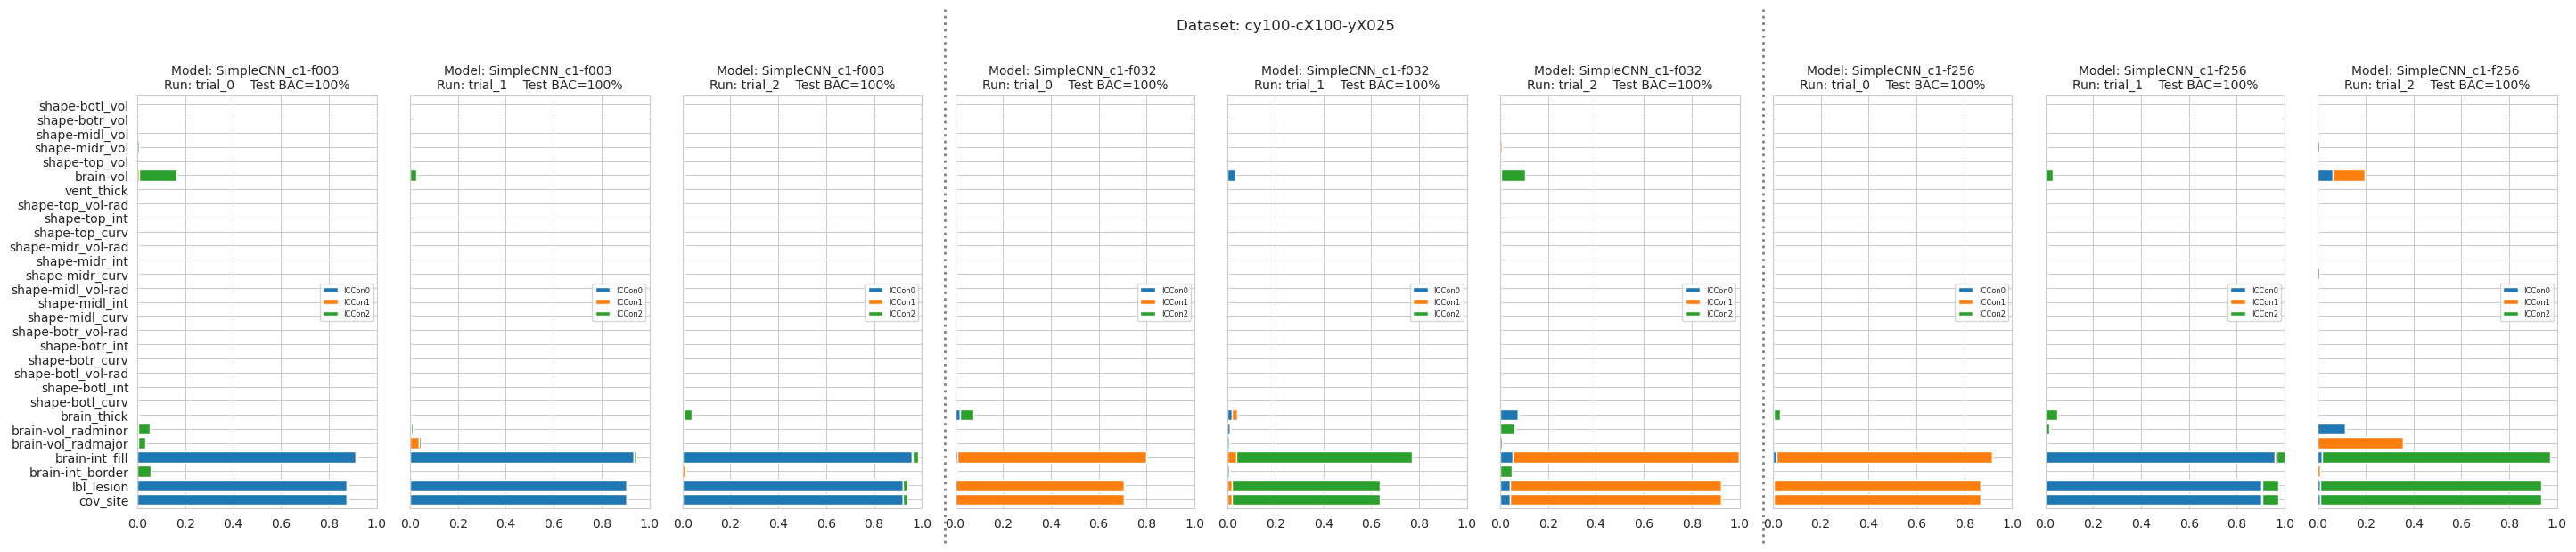

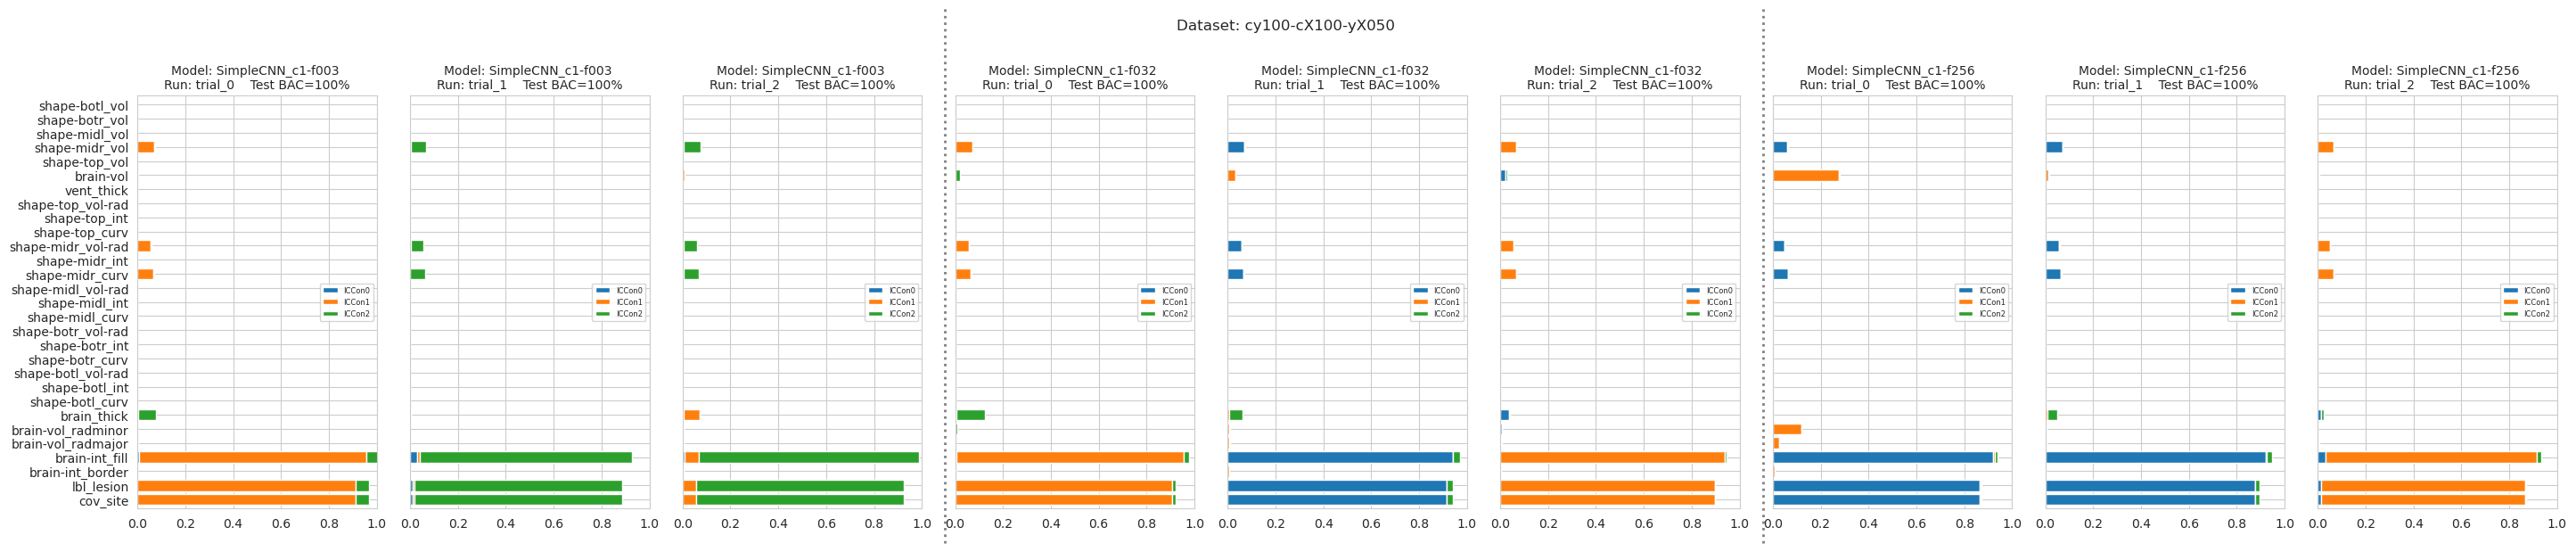

In [29]:
import matplotlib.transforms as mtrans

if RUN_ICCon:
    N_COMPONENTS=3

    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)
        model_change = []
        last_model = ''
        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):
            if last_model == '':
                model_change.append((model_name, False))
                last_model = model_name
            elif last_model != model_name:
                model_change.append((model_name, True))
                last_model = model_name
            else:
                model_change.append((model_name, False))
            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            # append the predicted logits
            # df_attrs["y_pred_logits"] = log['y_pred']
            # df_attrs["y_pred_class"] = log['y_pred']>0.5
            # for 5 variables in the metadata table compute the metric
            conf_subset =  df_attrs.columns.tolist() #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            
            # set the N_COMPONENTS of ICCons same as the number of confound variables + lbl
            # N_COMPONENTS = np.min([*log['act'].shape, 5]) # sklearn: Number of components to keep should be in [1, min(n_samples, n_features, n_targets)].
            df_scores = pd.DataFrame(index=[f"ICCon{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

            ### (2) Compute PLS
            df_scores_lbl_cov = df_attrs.copy()#[['lbl_lesion', 'cov_site',]]
            try:
                X_cca, cca = compute_pls_ica(log['act'], df_scores_lbl_cov, n_components=N_COMPONENTS) 
            except Exception as e:
                print(f"[ERROR] CCA failed to converge for {model_name} on {dataset} at run {run}. Skipping... \n{e}")
                continue

            # save the computed PLS's weights 
            
            for conf in conf_subset:
                conf_var = df_attrs[conf]
                for i in range(X_cca.shape[-1]):
                    df_scores.at[f"ICCon{i}", conf] = compute_dcor_sq(X_cca[:,i], 
                                                                    conf_var.astype(float))

            df_scores.T.plot.barh(ax=ax, width=0.8, stacked=True)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})
            ax.set_xlim(0, 1.)

        plt.tight_layout()

        ### draw verticle lines to separate different model_name
        # Get the bounding boxes of the axes including text decorations
        with warnings.catch_warnings(): # catch and ignore FutureWarning
            warnings.simplefilter(action='ignore', category=FutureWarning)
            r = fig.canvas.get_renderer()
            get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
            bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)
            #Get the X1 coordinate of each bounding box
            xmax = np.array(list(map(lambda b: b.x0, bboxes.flat)))
            # Draw a verticle lines at the coordinates where the model_name changes
            for x, (_, changed) in zip(xmax, model_change):
                if changed:
                    line = plt.Line2D([x,x], [0,1], transform=fig.transFigure, 
                                    linestyle=':', color='grey', linewidth=2)
                    fig.add_artist(line)
        
        plt.show()


### Visualize the ICCons

(1) plot the activations

In [30]:
# for dataset in unique_datasets:
    
#     logs_3d = [log for log in logs if ((log[0]==dataset) and ('-f003' in log[1]))]

    # # create a 3D scatter plot of the activations
    # fig = plt.figure(figsize=plt.figaspect(1/len(logs_3d)))
    # fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

    # for i, (dataset, model_name, run, log) in enumerate(logs_3d):
    #     ax = fig.add_subplot(1, len(logs_3d), i+1, projection='3d')
    #     ax.scatter(log['act'][:,0], log['act'][:,1], log['act'][:,2], 
    #             c=log['y_pred'], cmap='coolwarm')
        
    # plt.show()
    # Import dependencies

In [31]:
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

## (1) select a specfic dataset and run
dataset_idx = 2
run_idx = 1
dataset = unique_datasets[dataset_idx]
log_set = [log for log in logs if ((log[0]==dataset) and ('-f003' in log[1]))][run_idx]

(dataset, model_name, run, log) = log_set

print(f"{'-'*100} \nDataset: {dataset} \t Model: {model_name} \t Run: {run}")

# first get the attributes table for y
df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
# make the table values numerical using the DeepRepVizBackend
drv = DeepRepVizBackend(conf_table=df_attrs, 
                        ID_col='subjectID', label_col='lbl_lesion', 
                        best_ckpt_by="test_loss")
# reorder to match the IDs of the model results and the confound table
df_attrs = drv.df_conf.loc[log['IDs']]

## (2) create a 3D scatter plot of the activations
# Color points by confounder
color_by = 'brain-int_fill'
fig = go.Figure(go.Scatter3d(
    x=log['act'][:,0], y=log['act'][:,1], z=log['act'][:,2],
    mode='markers',
    marker={'size':3, 'opacity': 0.3, 'color':df_attrs[color_by]},
    name=f'H(l-1) activations \nColored by {color_by}', hovertext=log['y_pred'],
))


## (3) put the y_pred weights as a vector on the plot
wgt_pt = log['y_pred_weights']
wgt_pt /= np.linalg.norm(wgt_pt) # normalize it
y_pred_color = 'rgb(84,48,5)'
# draw a line that extends in the directions by the weight vector, scaled by the std. dev. of the points
std_ext = 3*log['act'].std(axis=0).max()
# avg_pt = log['act'].mean(axis=0)
fig.add_trace(go.Scatter3d( 
                       x=[-wgt_pt[0]*std_ext, wgt_pt[0]*std_ext],
                       y=[-wgt_pt[1]*std_ext, wgt_pt[1]*std_ext], 
                       z=[-wgt_pt[2]*std_ext, wgt_pt[2]*std_ext],
                       marker = dict(size=1, color=y_pred_color),
                       line = dict(color=y_pred_color, width=4),
                       name=f'y_pred ({log["test_acc"]*100:.0f}% Acc)'
                     ))


## (4) draw the PCAs
n_components=3
X_pca, pca = compute_pca(log['act'], n_components=n_components)
pca_color = 'rgb(200,50,0)'
for i in range(n_components):
    pca_pt = pca.components_[i]
    pca_pt /= np.linalg.norm(pca_pt) # normalize it 
    pca_pt = pca_pt * pca.explained_variance_[i] # scale by its variance explained
    fig.add_trace(go.Scatter3d(
        x=[0, pca_pt[0]*std_ext],
        y=[0, pca_pt[1]*std_ext],
        z=[0, pca_pt[2]*std_ext],
        marker = dict(size=1, color=pca_color),
        line = dict(color=pca_color, width=2),
        name=f'PCA{i} (R2={pca.explained_variance_ratio_[i]*100:.0f}%)'
    ))


## (4) draw the ICAs
# X_ica, ica = compute_ica(log['act'], n_components=n_components)
# ica_color = 'rgb(0,50,200)'
# for i in range(n_components):
#     ica_pt = ica.components_[i]
#     ica_pt /= np.linalg.norm(ica_pt) # normalize it
#     fig.add_trace(go.Scatter3d(
#         x=[0, ica_pt[0]*std_ext],
#         y=[0, ica_pt[1]*std_ext],
#         z=[0, ica_pt[2]*std_ext],
#         marker = dict(size=1, color=ica_color),
#         line = dict(color=ica_color, width=2),
#         name=f'ICA{i}'
#     ))


## (5) draw the ICCons
X_ICCons, (pls, ica) = compute_pls_ica(log['act'], y=df_attrs, n_components=n_components)
ICCon_color = 'rgb(0,200,50)'
for i in range(n_components):
    ica_pt = ica.components_[i]
    ica_pt /= np.linalg.norm(ica_pt) # normalize it
    fig.add_trace(go.Scatter3d(
        x=[0, ica_pt[0]*std_ext],
        y=[0, ica_pt[1]*std_ext],
        z=[0, ica_pt[2]*std_ext],
        marker = dict(size=1, color=ICCon_color),
        line = dict(color=ICCon_color, width=2),
        name=f'ICCon{i}'
    ))

### (-1) Render the plot.
fig.update_layout(
    # scene=dict(camera_eye=dict(x=0.05, y=-2.6, z=2)),
                  margin=dict(t=0, b=0, l=0, r=0))
plotly.offline.iplot(fig)

---------------------------------------------------------------------------------------------------- 
Dataset: cy025-cX025-yX025 	 Model: SimpleCNN_c1-f003 	 Run: trial_1


### Understanding Canonical correlation analysis